# Final Project: Bank Marketing Analysis

**Name:** Jonathan Pincince  
**Date:** July 26, 2024  
**Project Description:**
For my CSC 310 final project, I've chosen to do an analysis of a bank's marketing data. The goal of this analysis will be to determine if there are any clear patterns in which customers subscribe a term deposit to the bank, so that it's clear where most efforts should be concentrated. For example, if all customers with housing loans decided they couldn't afford this, then the bank can avoid spending resources pursuing these customers.  
In order to find these trends, I'll attempt to use every type of model we've studied, and try various parameters for each. People tend to make decisions at least semi-reasonably, so I'm hoping for a model that can help show how people come to their decisions regarding the marketing campaign. I expect to find at least a 2-3 demographic or financial trends that can help this bank use marketing resources effectively.

## Module Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CSC 310"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSC 310


In [2]:
%pip install scikit-optimize
%pip install shap

import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

np.set_printoptions(precision = 2)

In [3]:
# Function for computing confidence intervals from class lecture

def classification_confint(acc, n):
  '''
  Compute the 95% confidence interval for a classification problem.
    acc -- classification accuracy
    n -- number of samples
  Returns a tuple (lb, ub) where lb is the lower bound and ub is the upper bound
  '''
  import math
  interval = 1.96 * math.sqrt((acc * (1 - acc)) / n)
  lb = max(0, acc - interval)
  ub = min(1.0, acc + interval)
  return (lb, ub)

## Data Description

The data for this project comes from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing), and is composed of data related to direct marketing campaigns of a Portuguese bank. Each of the 4,521 rows represents one customer in the campaign, and each columns is a related attribute. The goal of the model built using this data will be to predict if the client will subscribe a term deposit (target variable listed as 'y' in the dataset). This will be evaluated using the 16 features of the data, which include:
 - Customer's personal info (age, job, marital status, education)
 - Customer's financial info (credit default status, balance, loan information)
 - Information related to the current marketing campaign (date, duration, and number of previous contacts, outcomes thereof).

In [4]:
bank = pd.read_csv("bank.csv", sep = ";")
print(bank.shape)
bank.head()

(4521, 17)


age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

There are four different .csv files available at the link above, but for this notebook's purposes the bank.csv file should suffice, since it contains the most important features as well as 4,521 customer samples, about 10% of the total. More is likely not necessary and will probably cause more complex models (like SVM) to become computationally prohibitive.

## Data Cleaning

In [5]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values, therefore no need for imputation and all rows and columns may be used for analysis.

In [6]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

There are seven features represented as int64 and nine represented as objects, with the target variable also being an object. This means some preprocessing will be necessary to turn the data into something that a machine learning model can handle.  
Ten of the features listed could be considered categorical, and the other six are numerical. Some of the categorical columns contain binary yes/no info and can simply be converted to binary types (default, housing, etc), while others will require some label encoding (job, marital, etc).

## Preliminary Analysis

In [7]:
bank.describe()

age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000

Among the numerical columns, 'day' is sort of a false numerical value, since a date is not a number in the traditional sense, and if there is a need to assess how long ago a customer was last contacted, there is the pdays column.  
Some interesting things to note from the numerical stats:
 - Most customers are middle aged
 - Most customers have a balance well under the 'average', indicating some wealthy outliers
 - Most customers haven't been part of a marketing campaign before, again with some high-end outliers driving up the average.

## Exploratory Analysis

### Feature Distributions

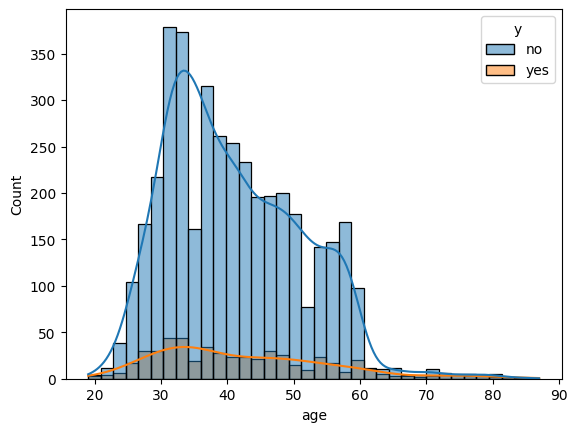

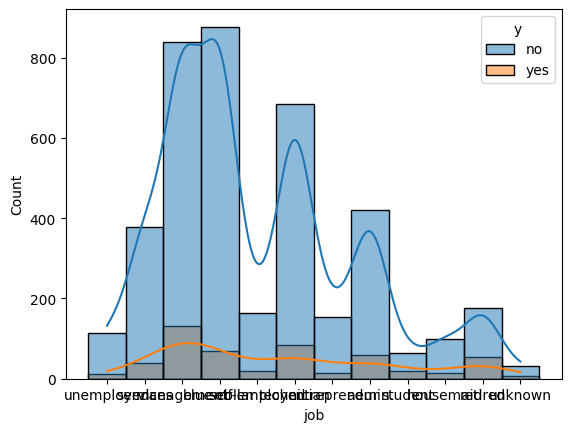

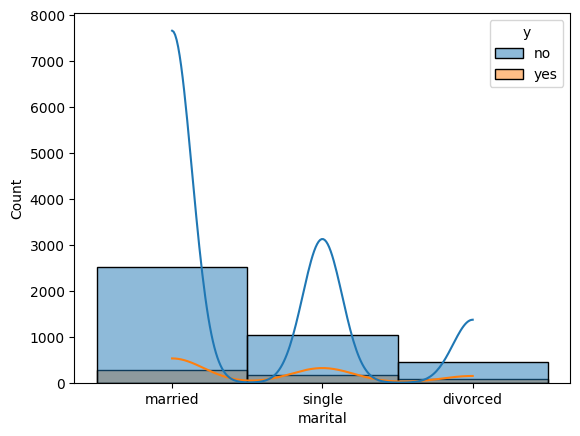

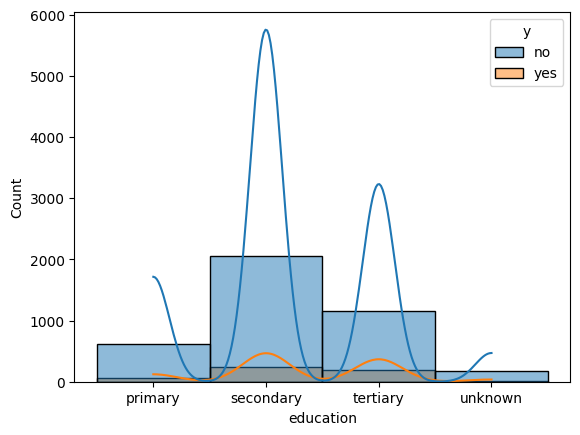

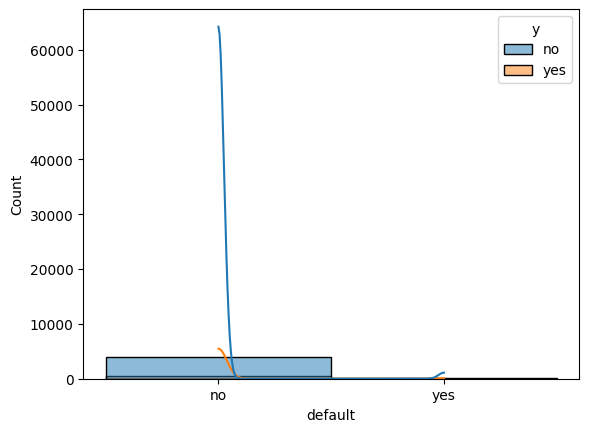

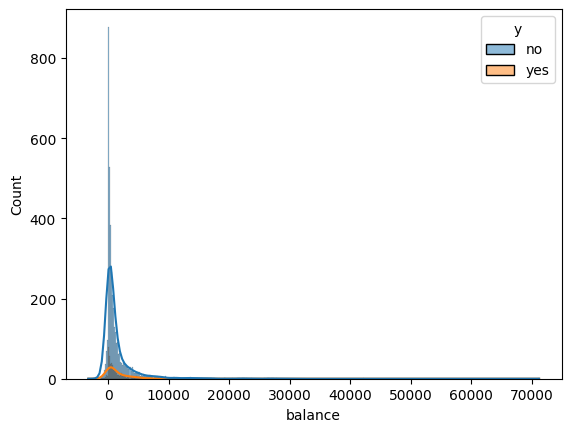

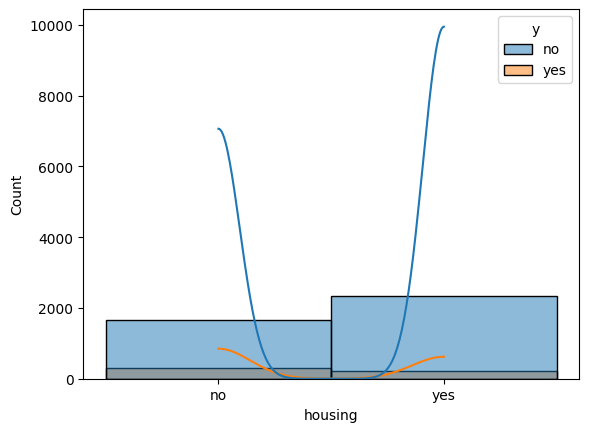

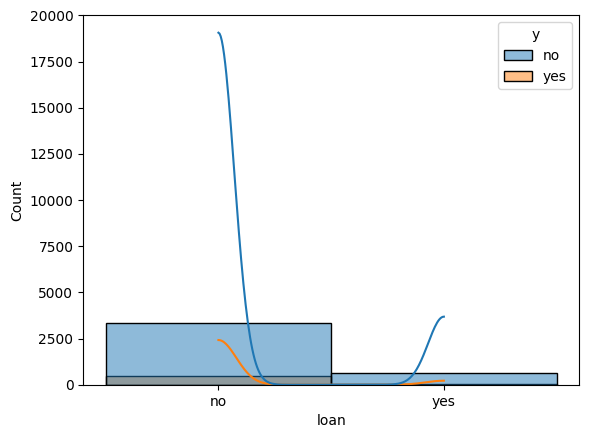

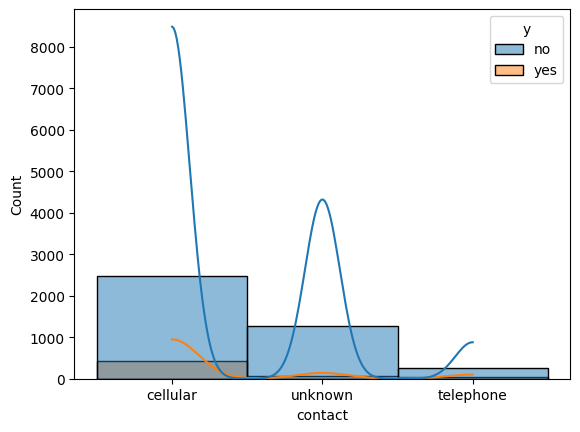

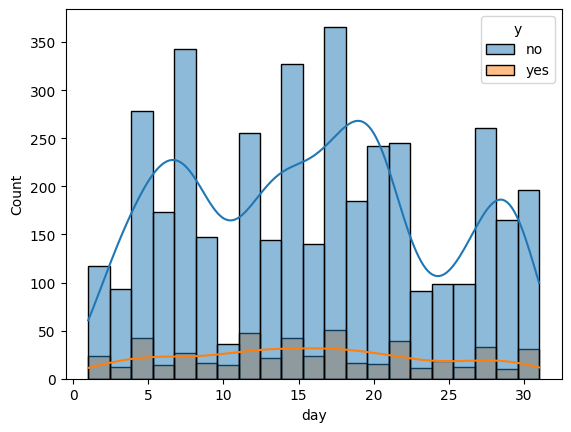

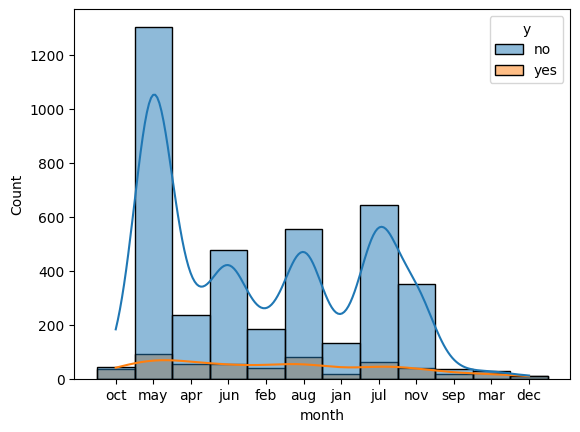

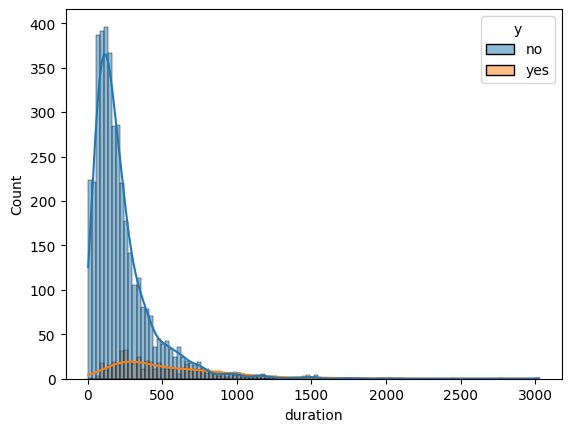

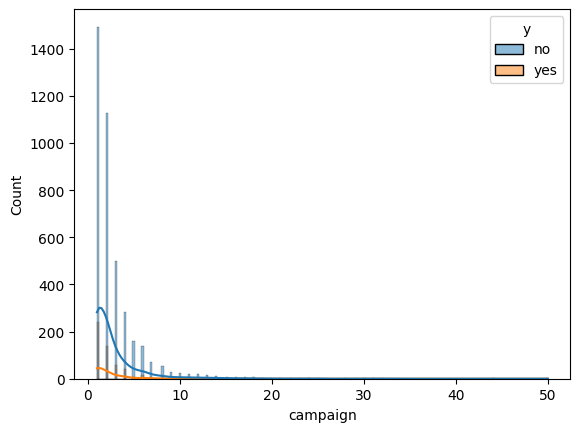

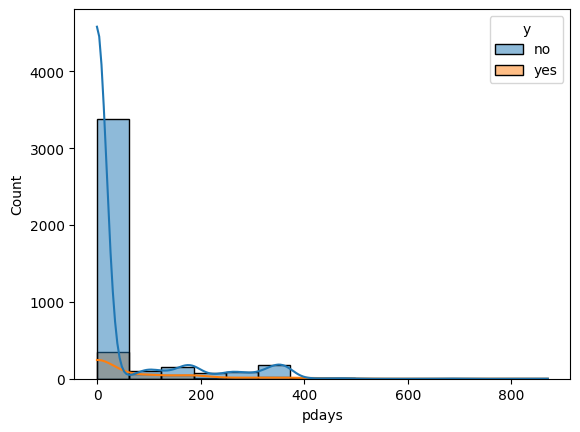

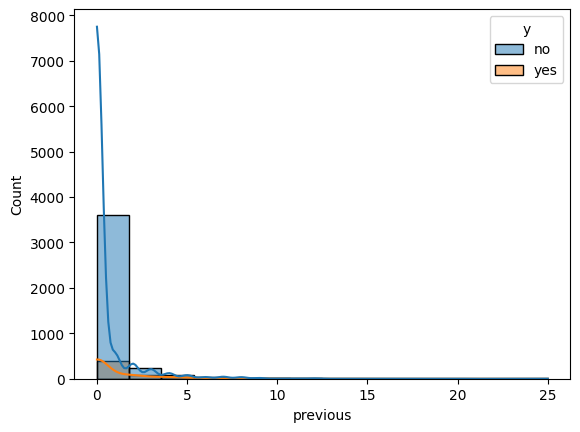

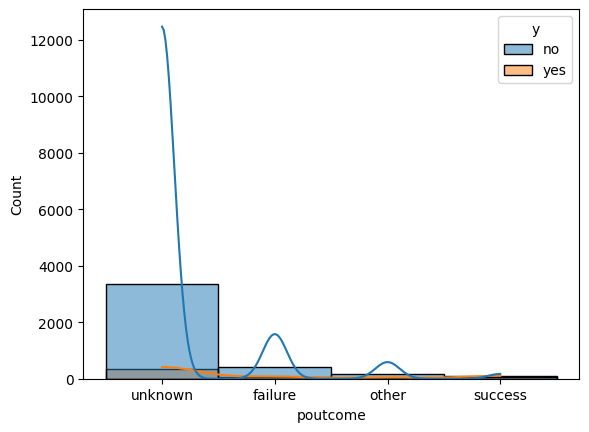

In [8]:
features = bank.drop(columns = 'y')

for col in features.columns:
  sns.histplot(data = bank, x = col, kde = True, hue = 'y')
  plt.show()

Some interesting notes from the feature distributions:
 - Relatively normal distribution of age, with a sharp drop around retirement age
 - Lots of married customers, and lots of college educated customers
 - A few outliers in terms of account balance that are strikingly far from the rest of the otherwise normally distributed data
 - Most contact is done via cellular phones
 - By far the most contact is done in the month of May, and in the summer months
 - Nearly all calls are less than five minutes
 - Very few campaigns have ended in success

### Target Distribution

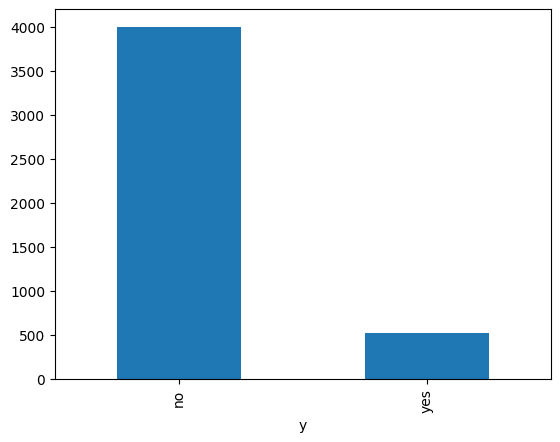

In [9]:
counts = bank.y.value_counts()
counts.plot(kind = 'bar')
plt.show()

From the bar graph of results, it's clear that the data are quite imbalanced, with most of the marketing campaigns ending in failure.

### Feature Correlations

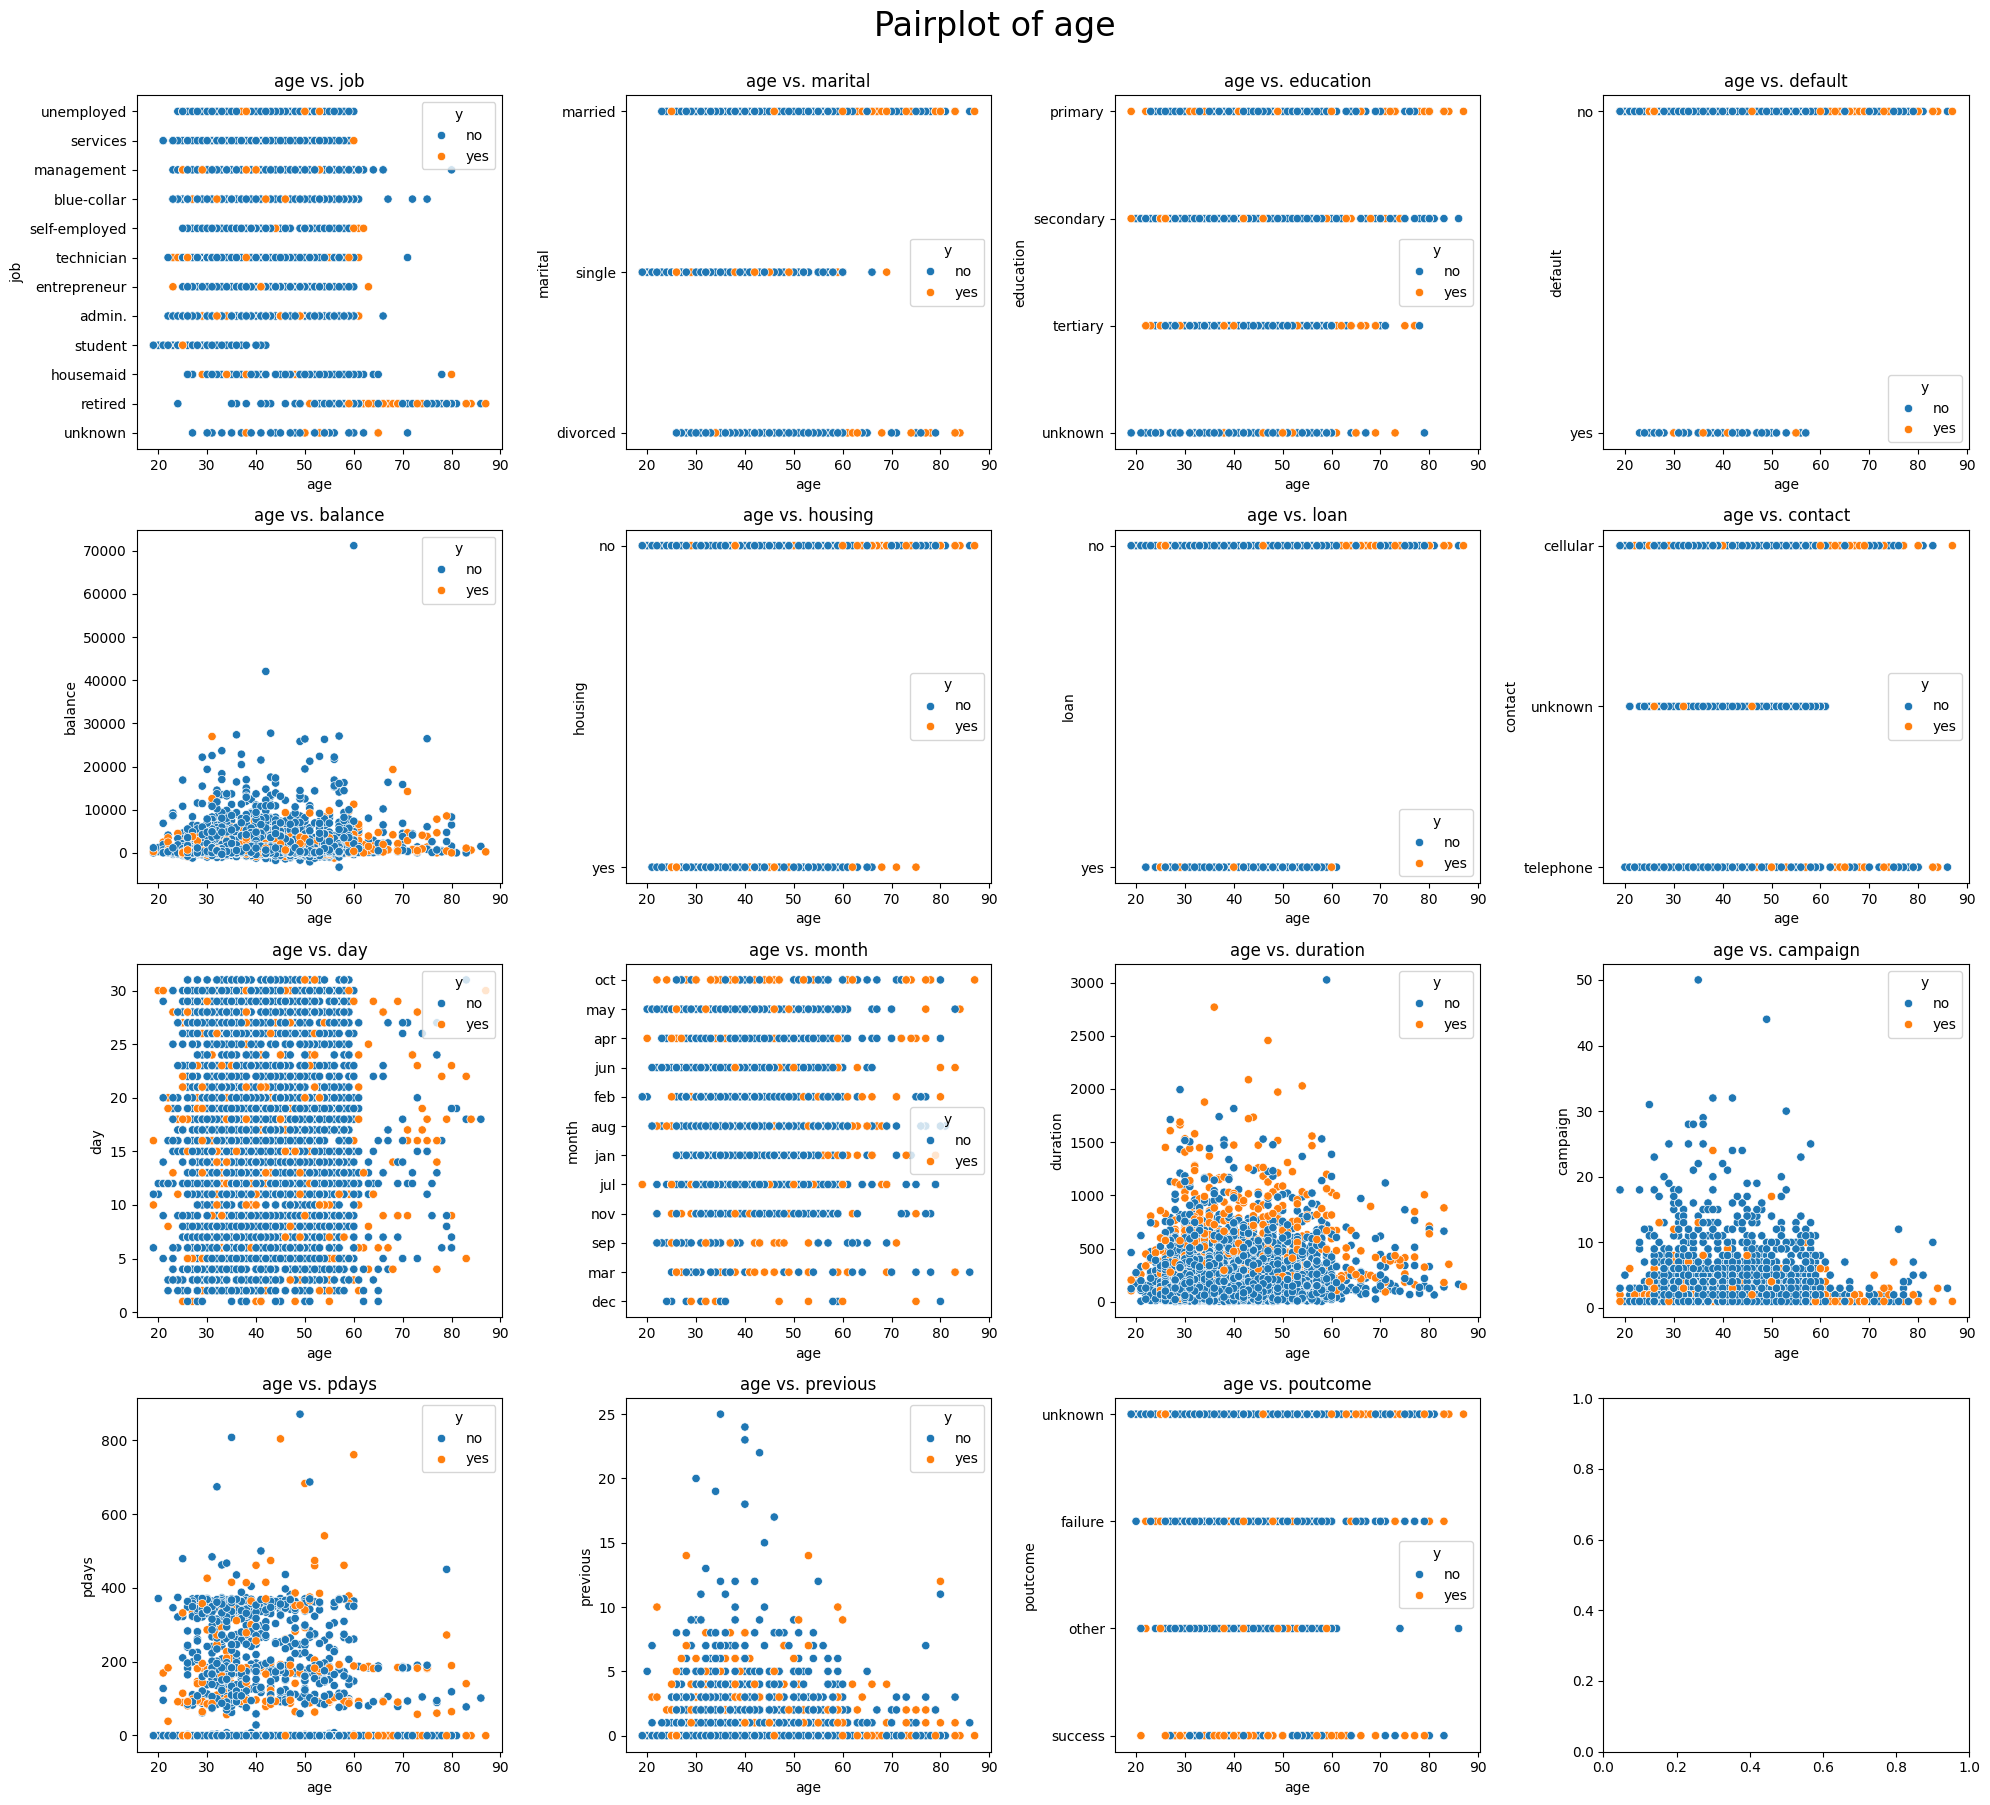

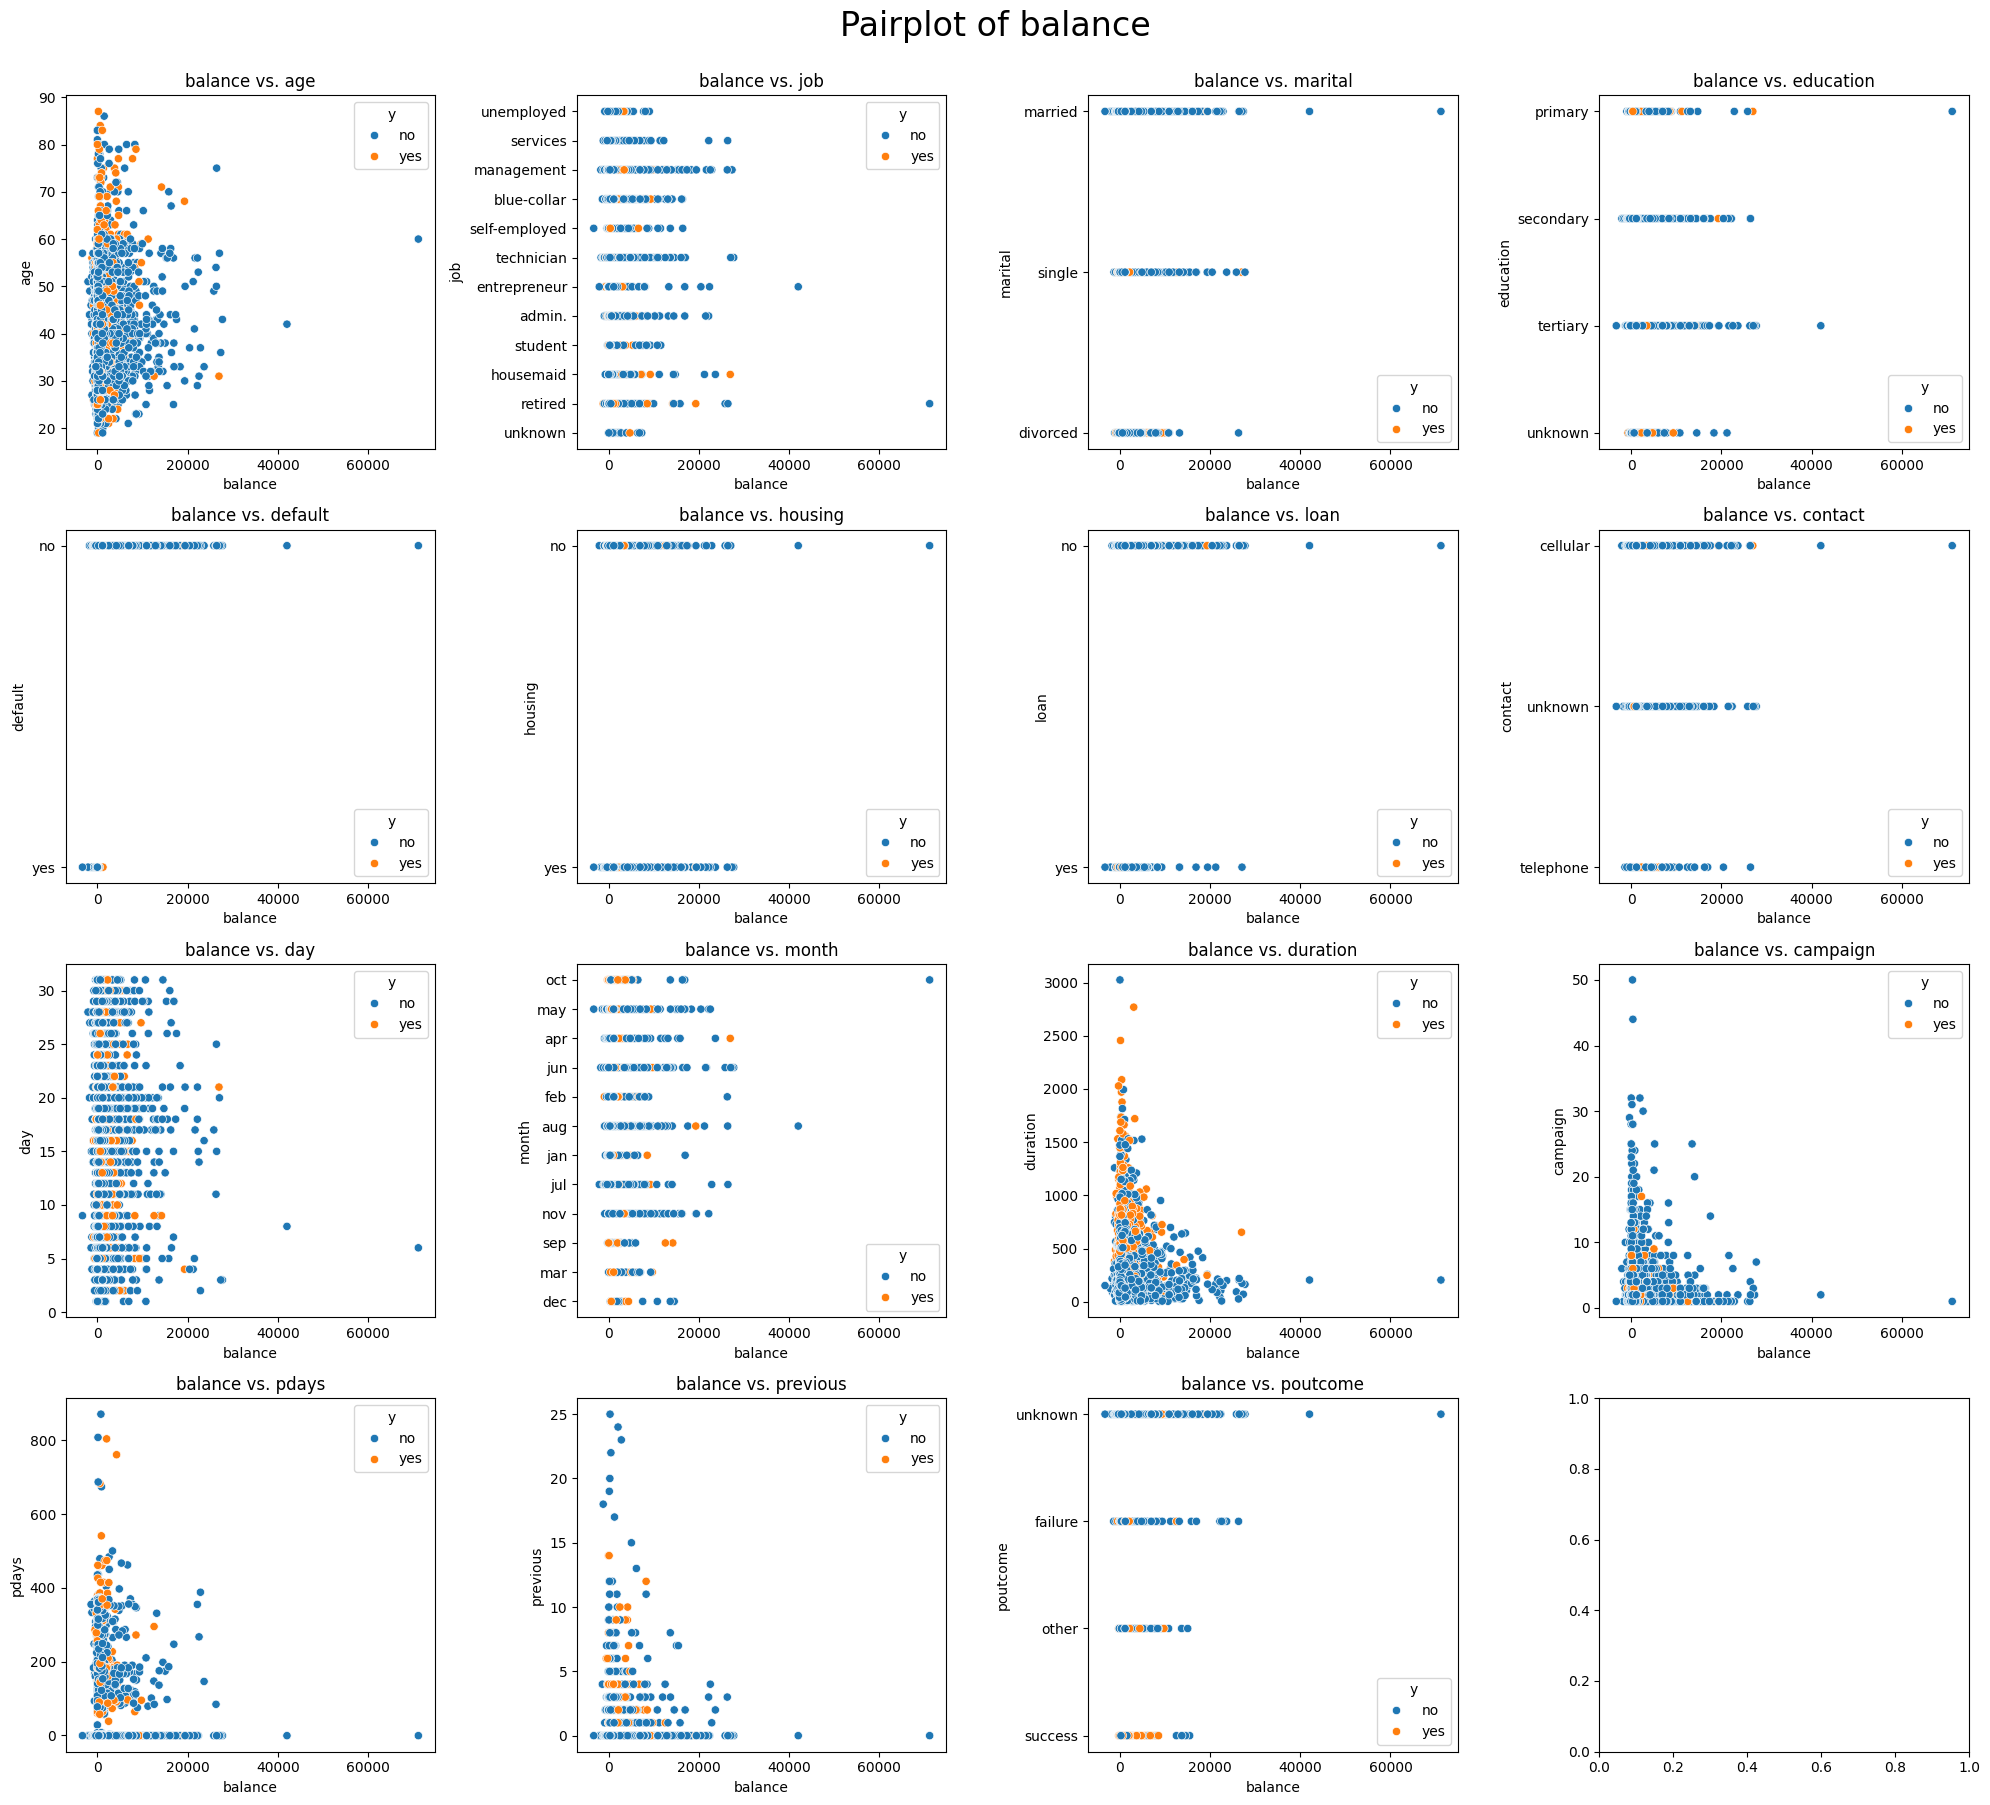

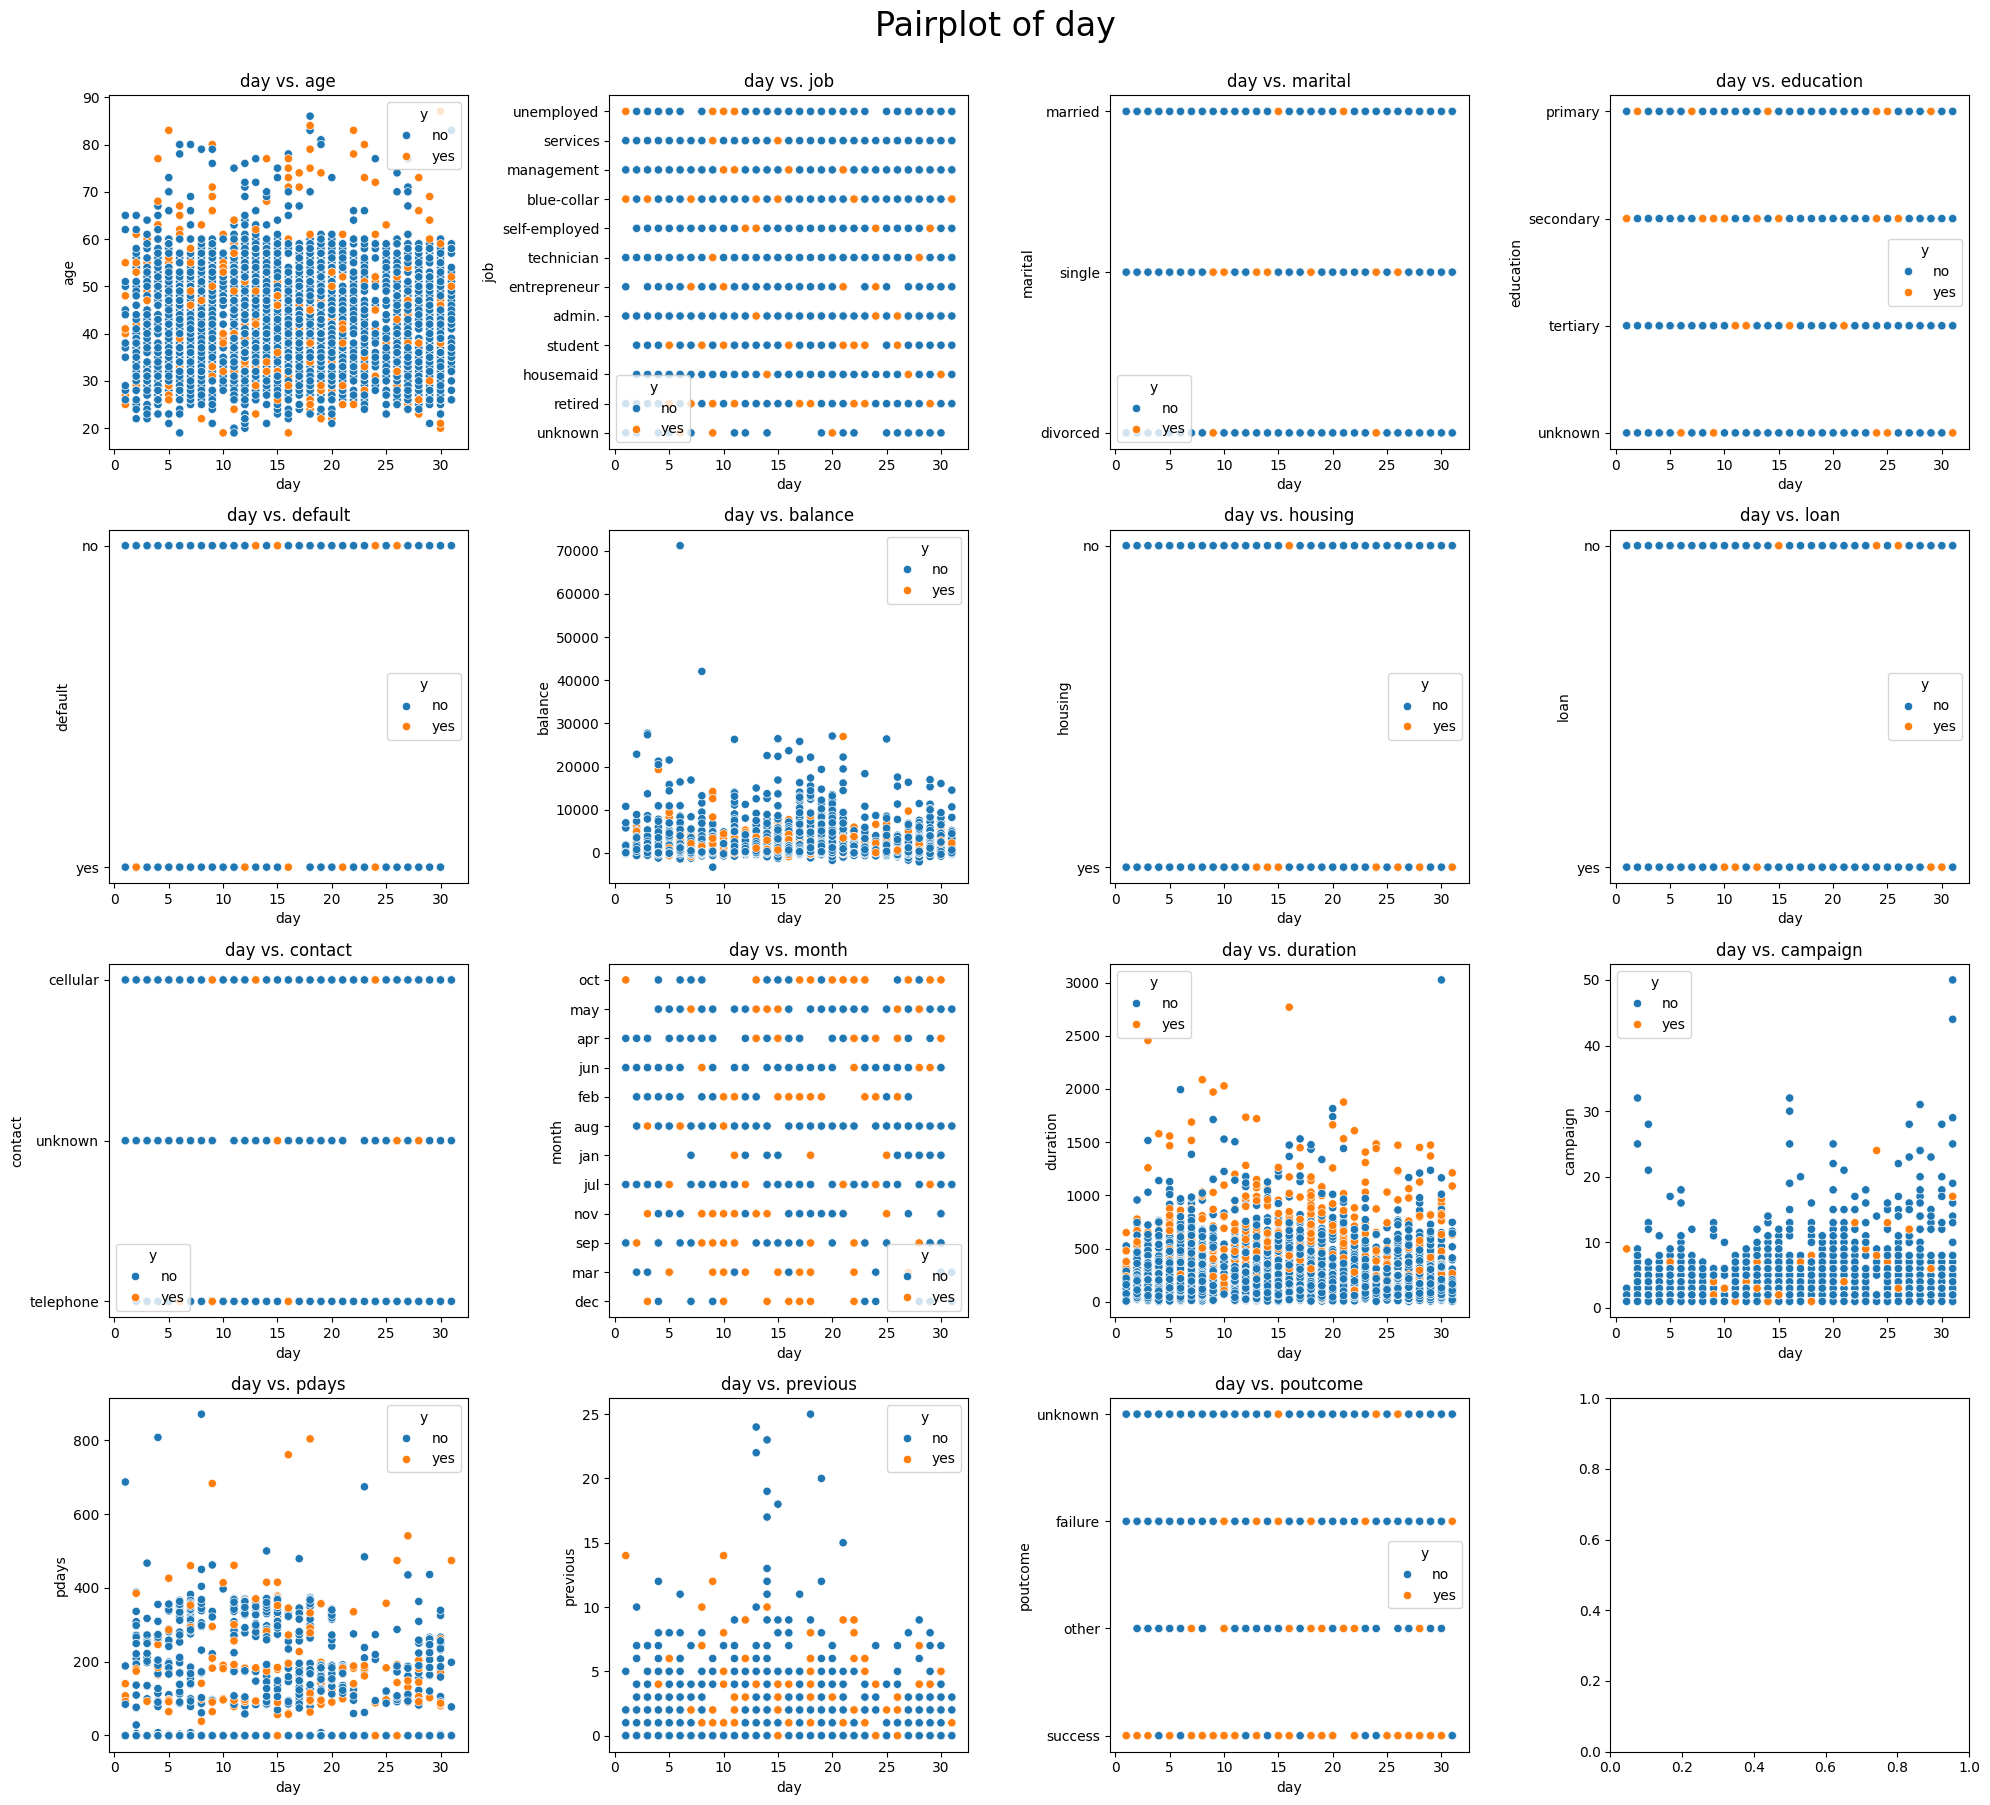

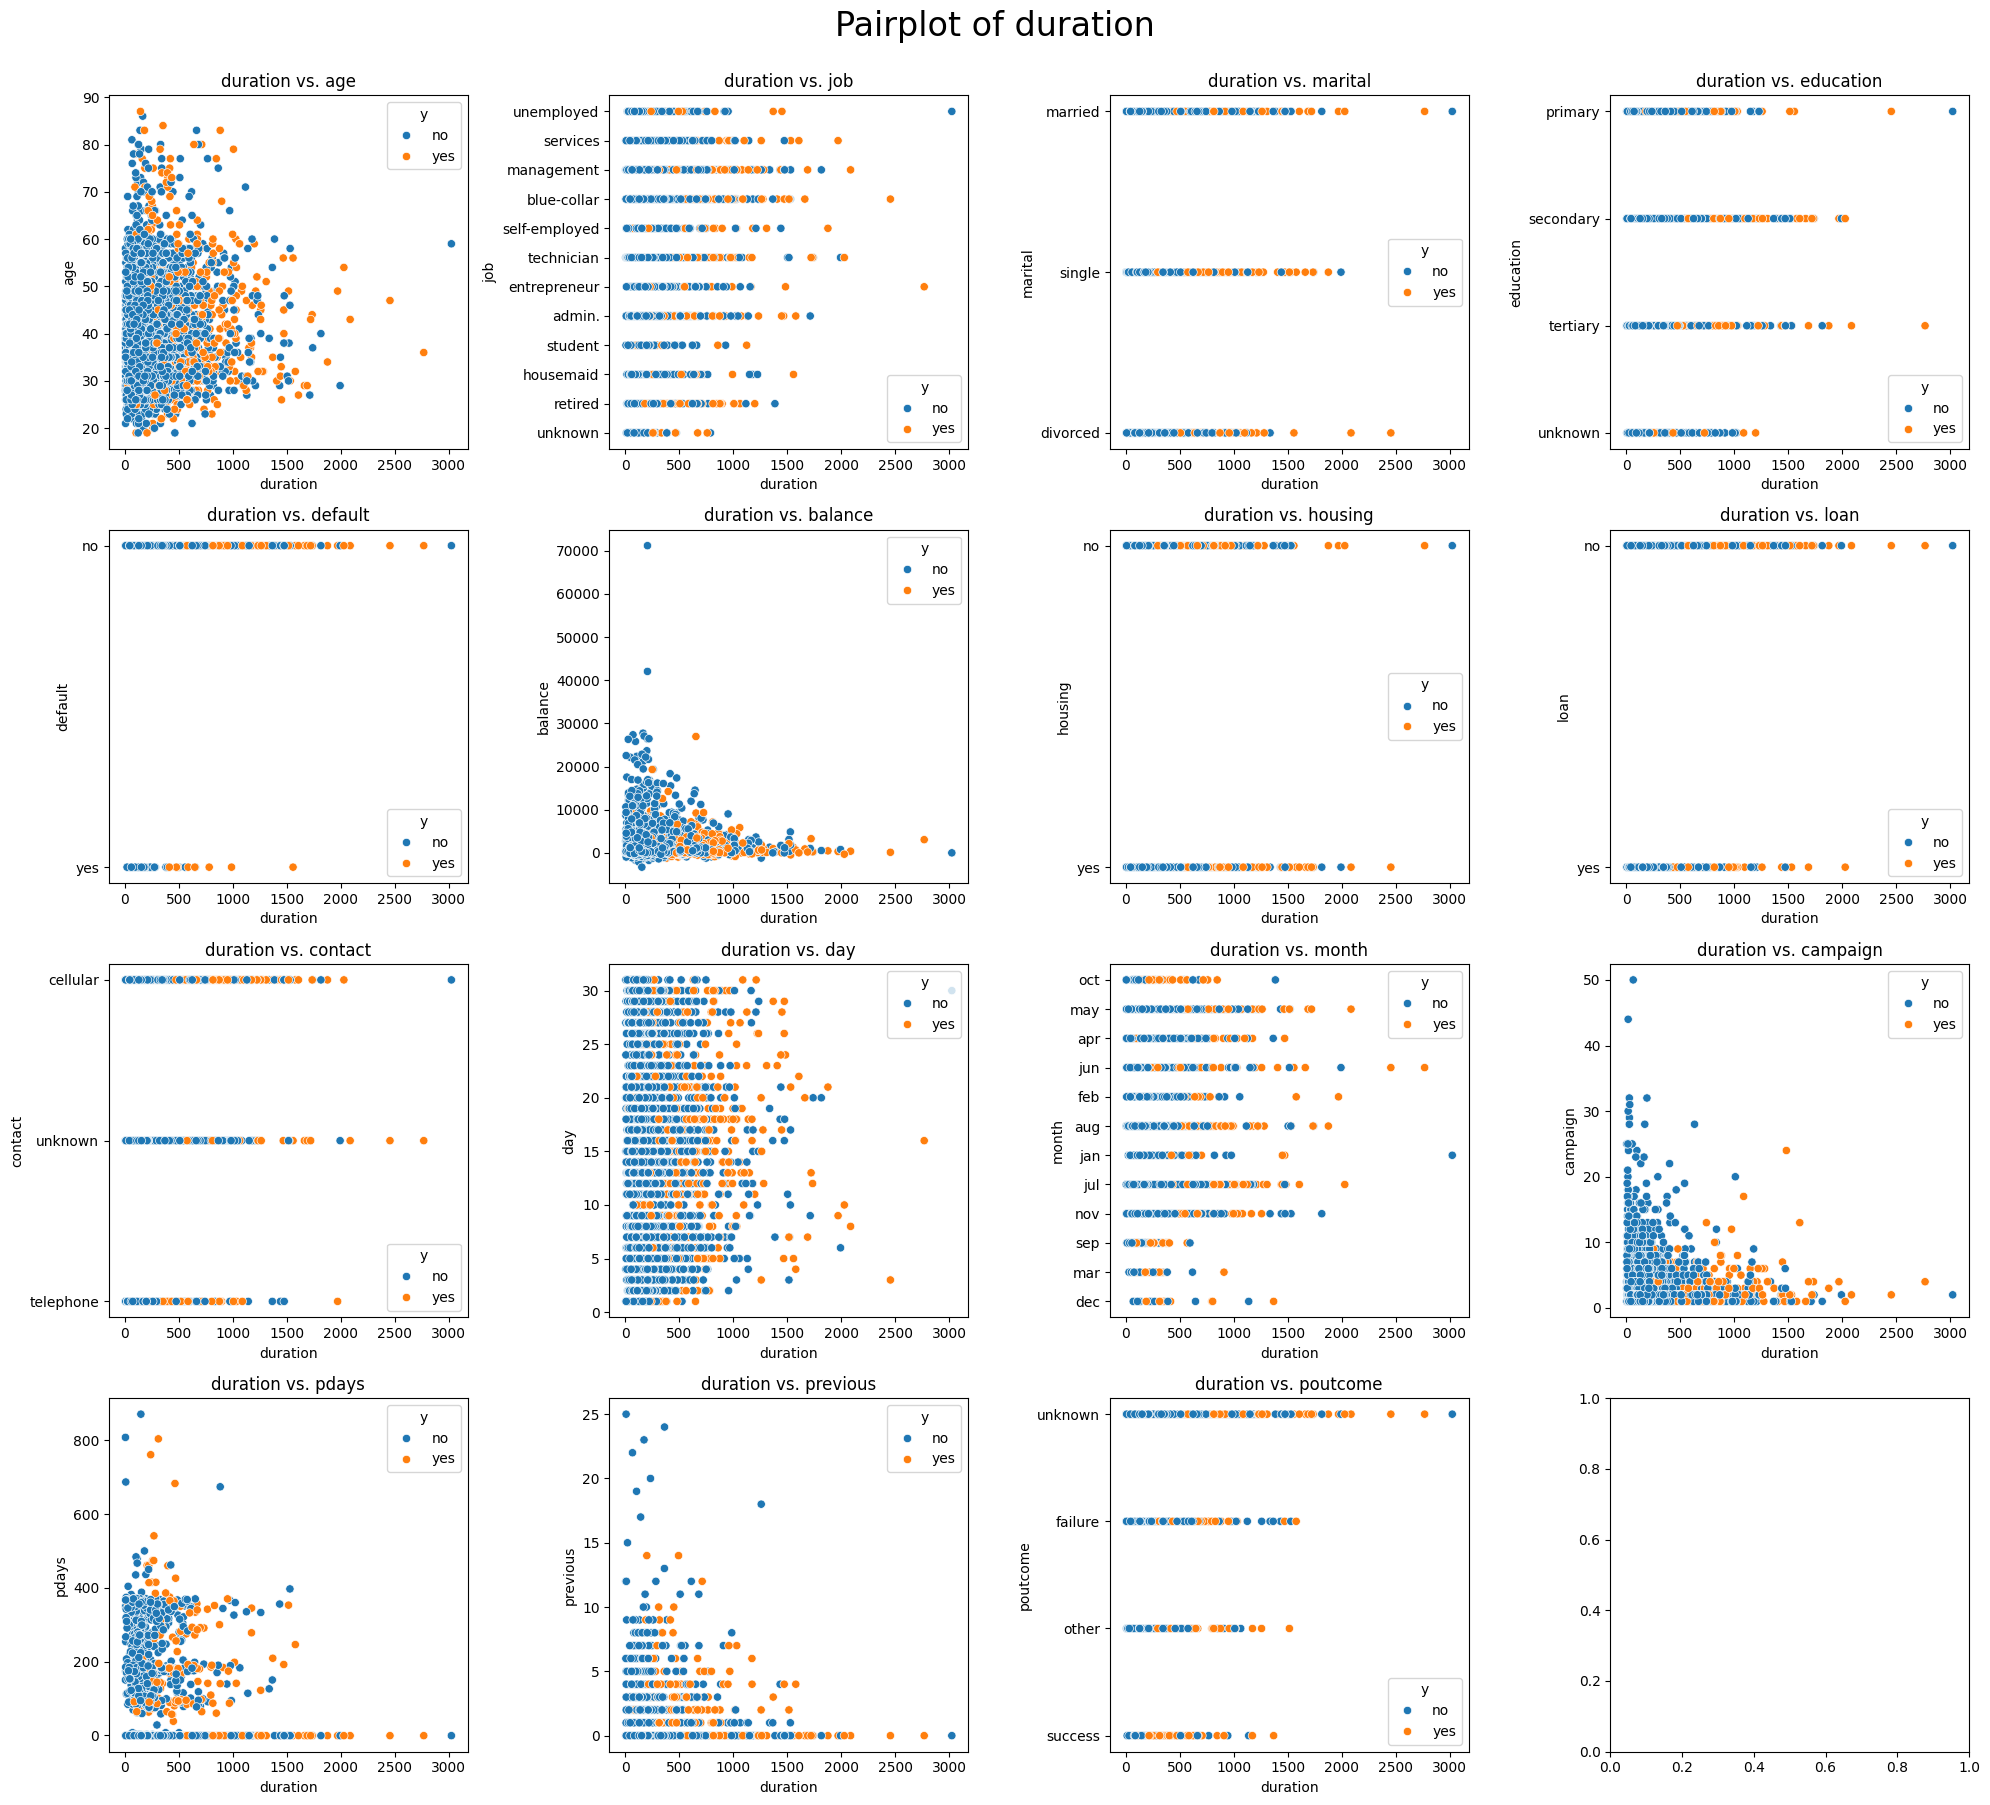

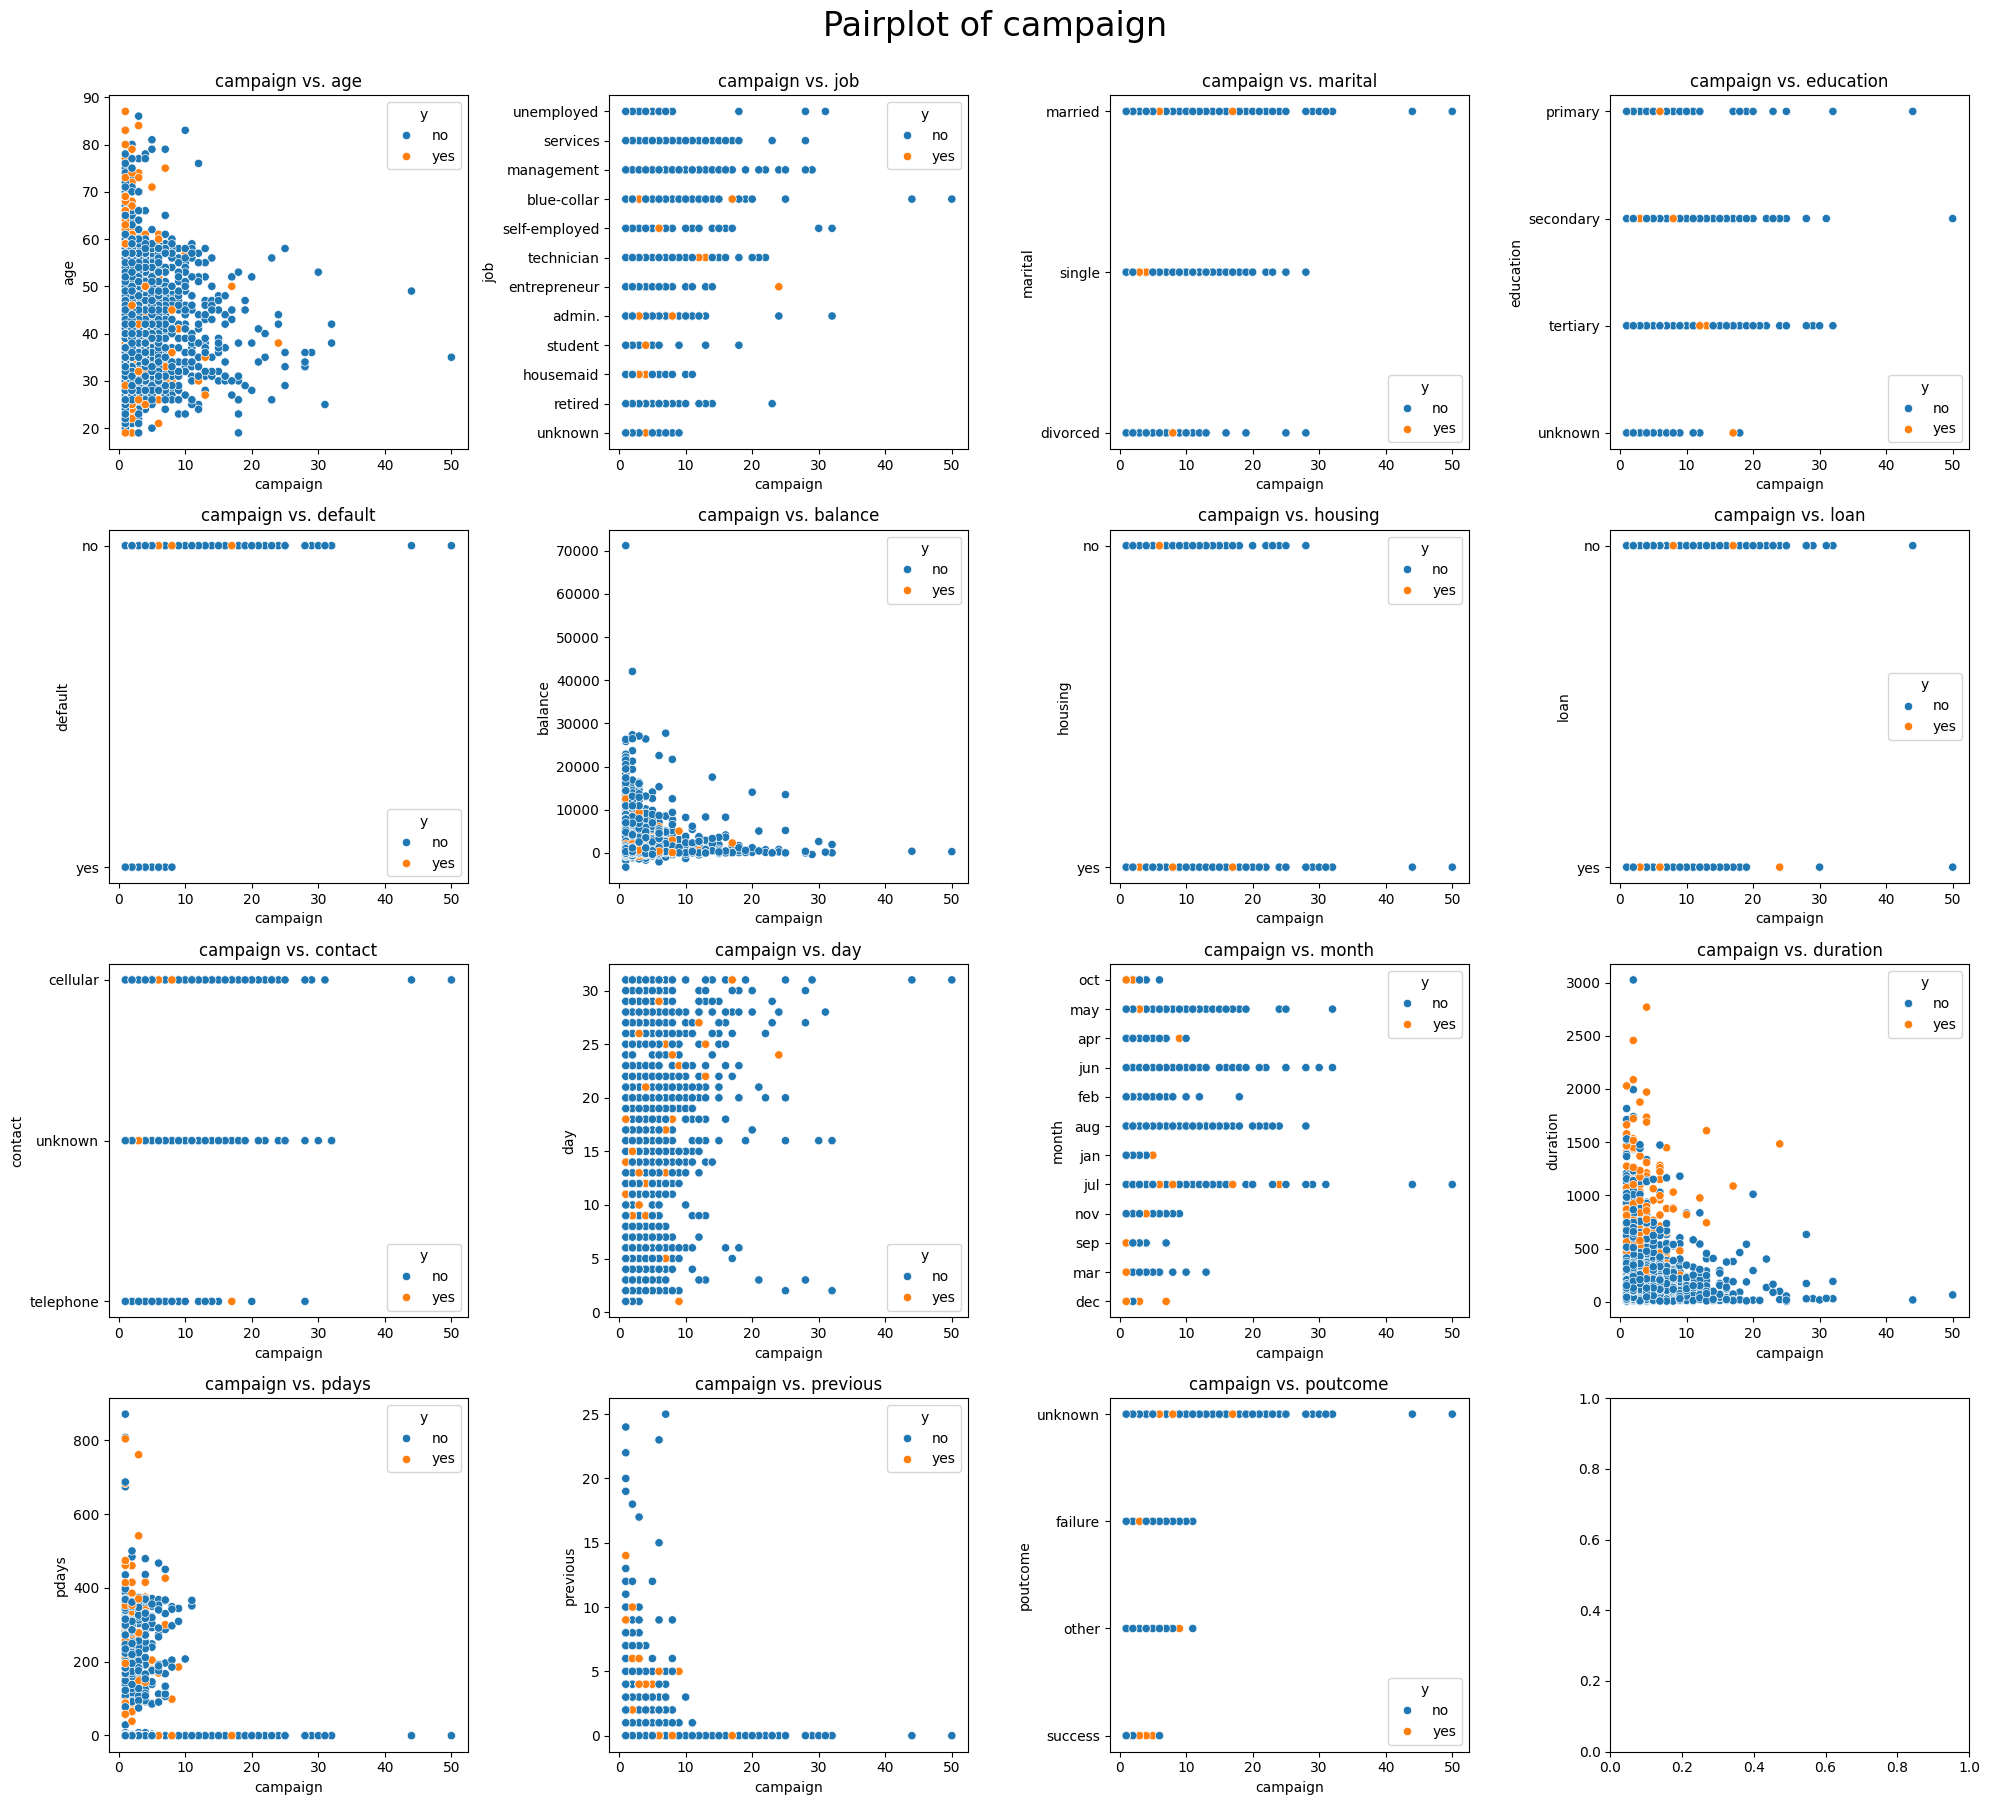

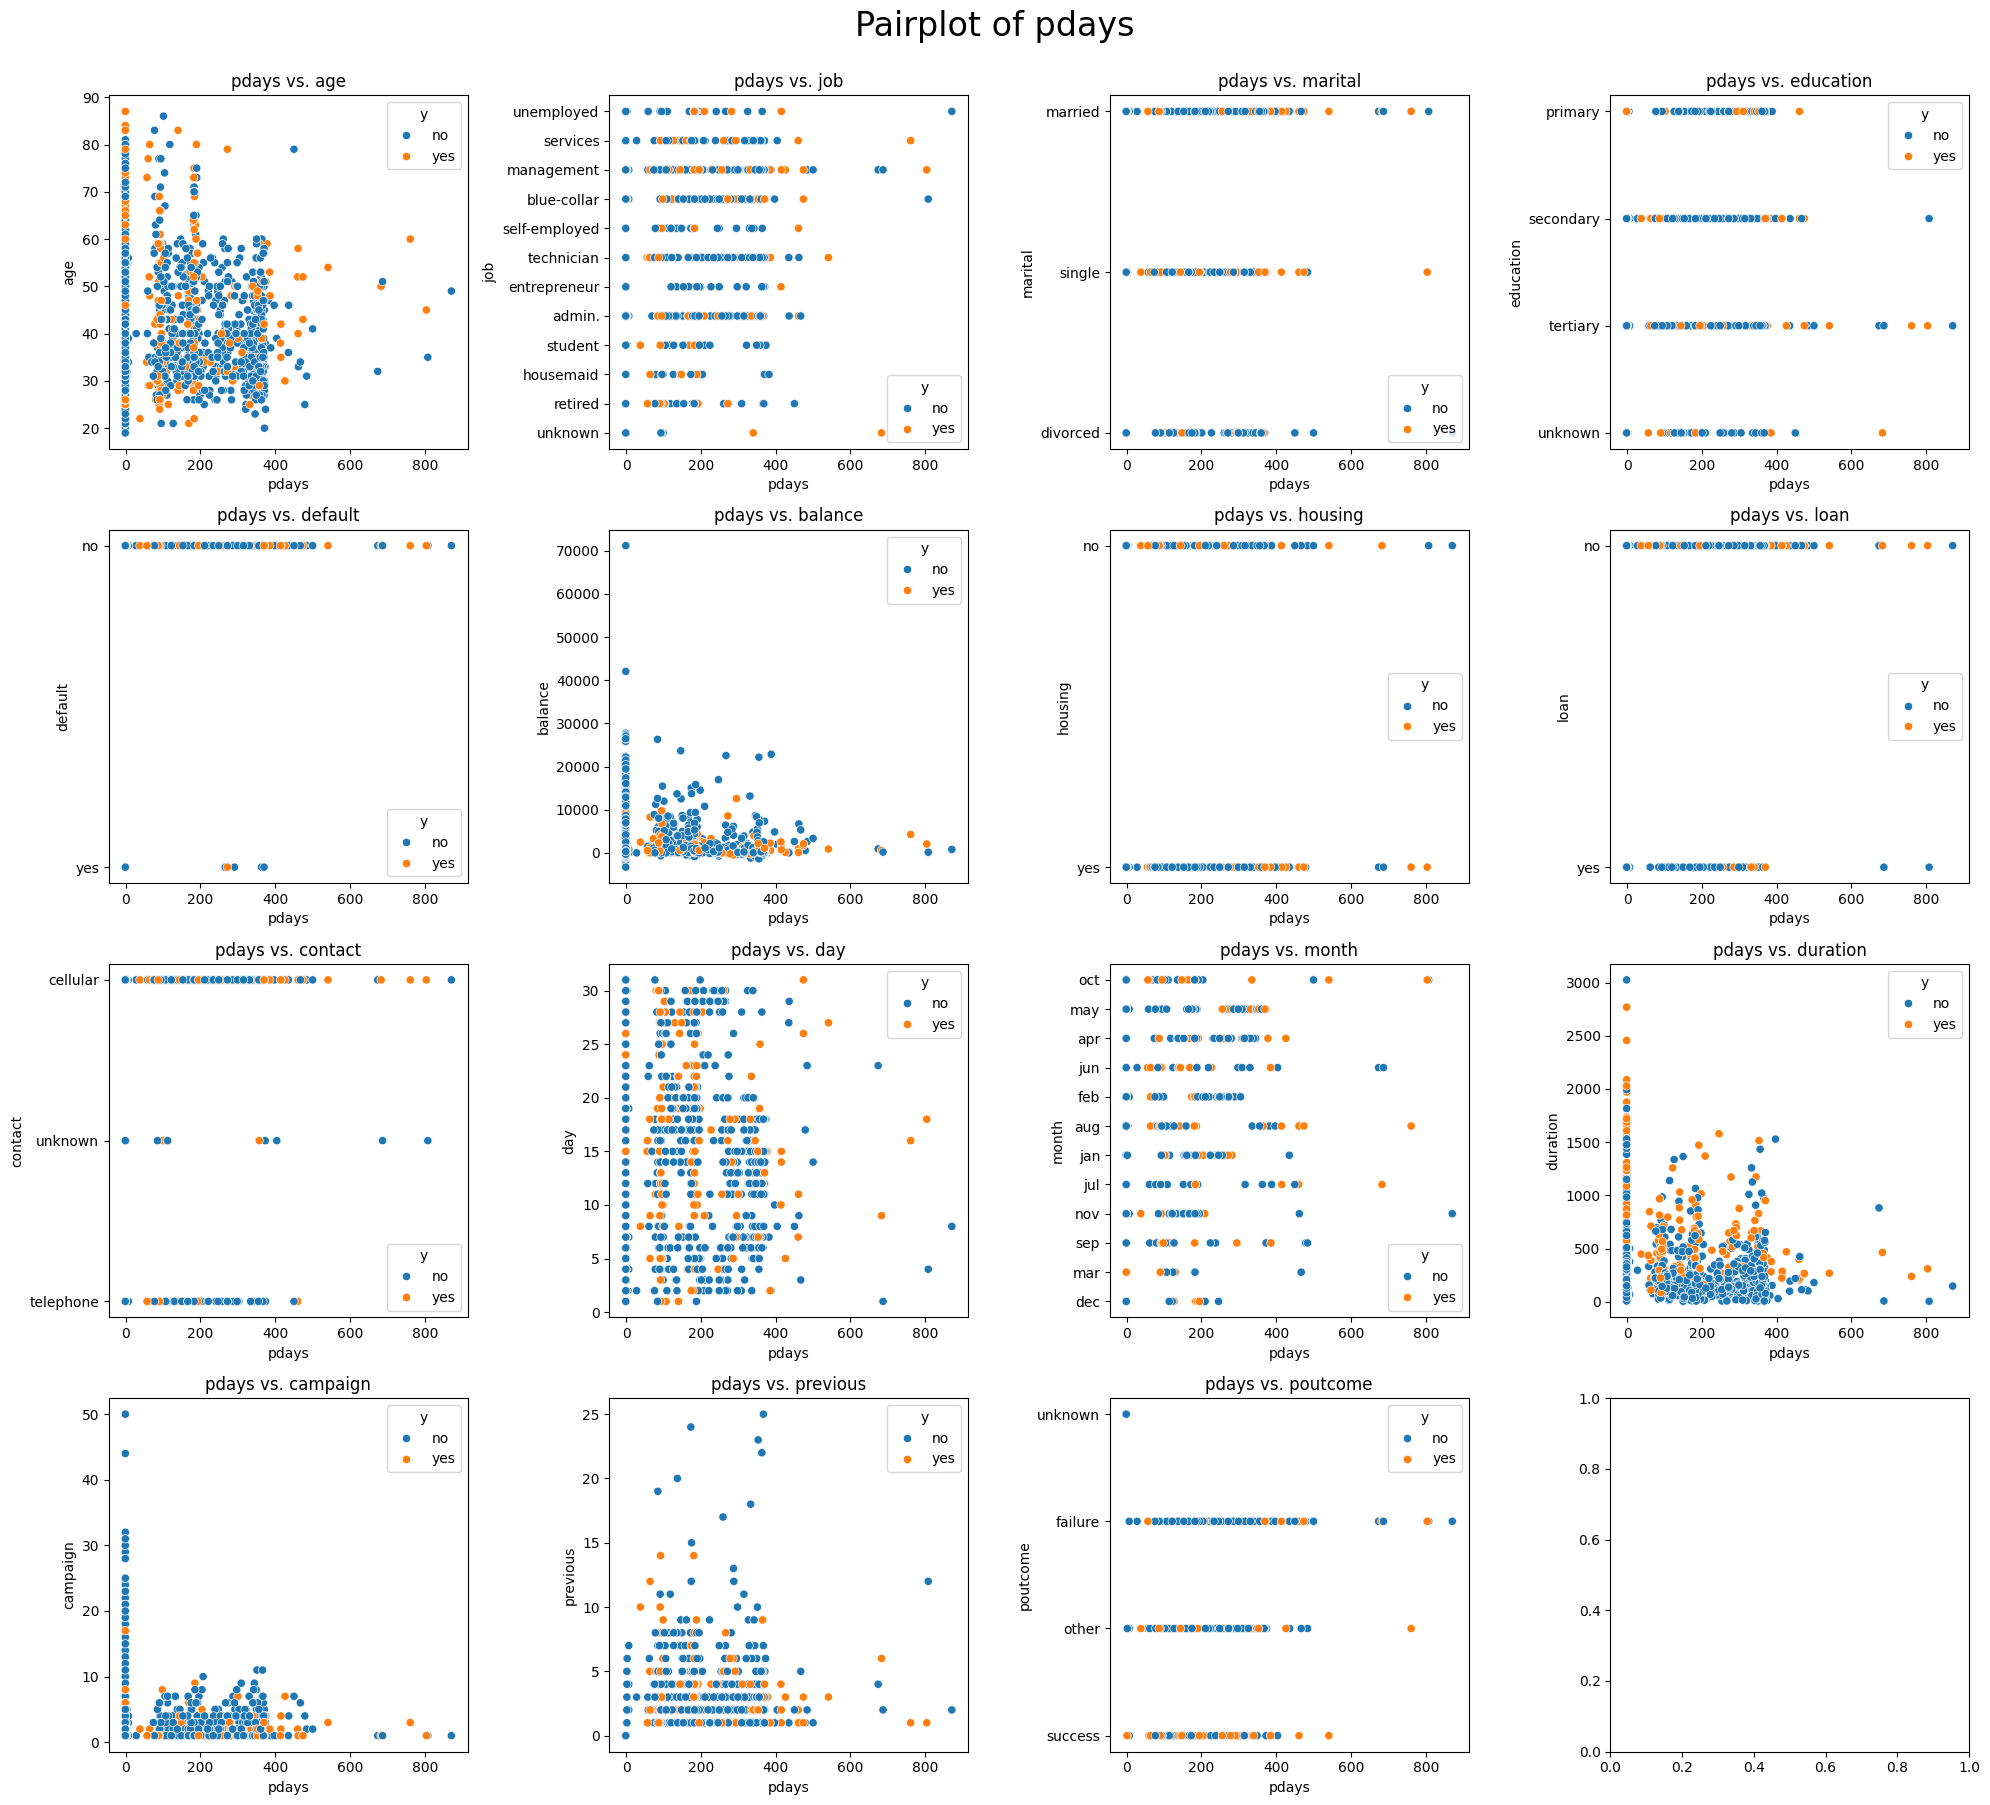

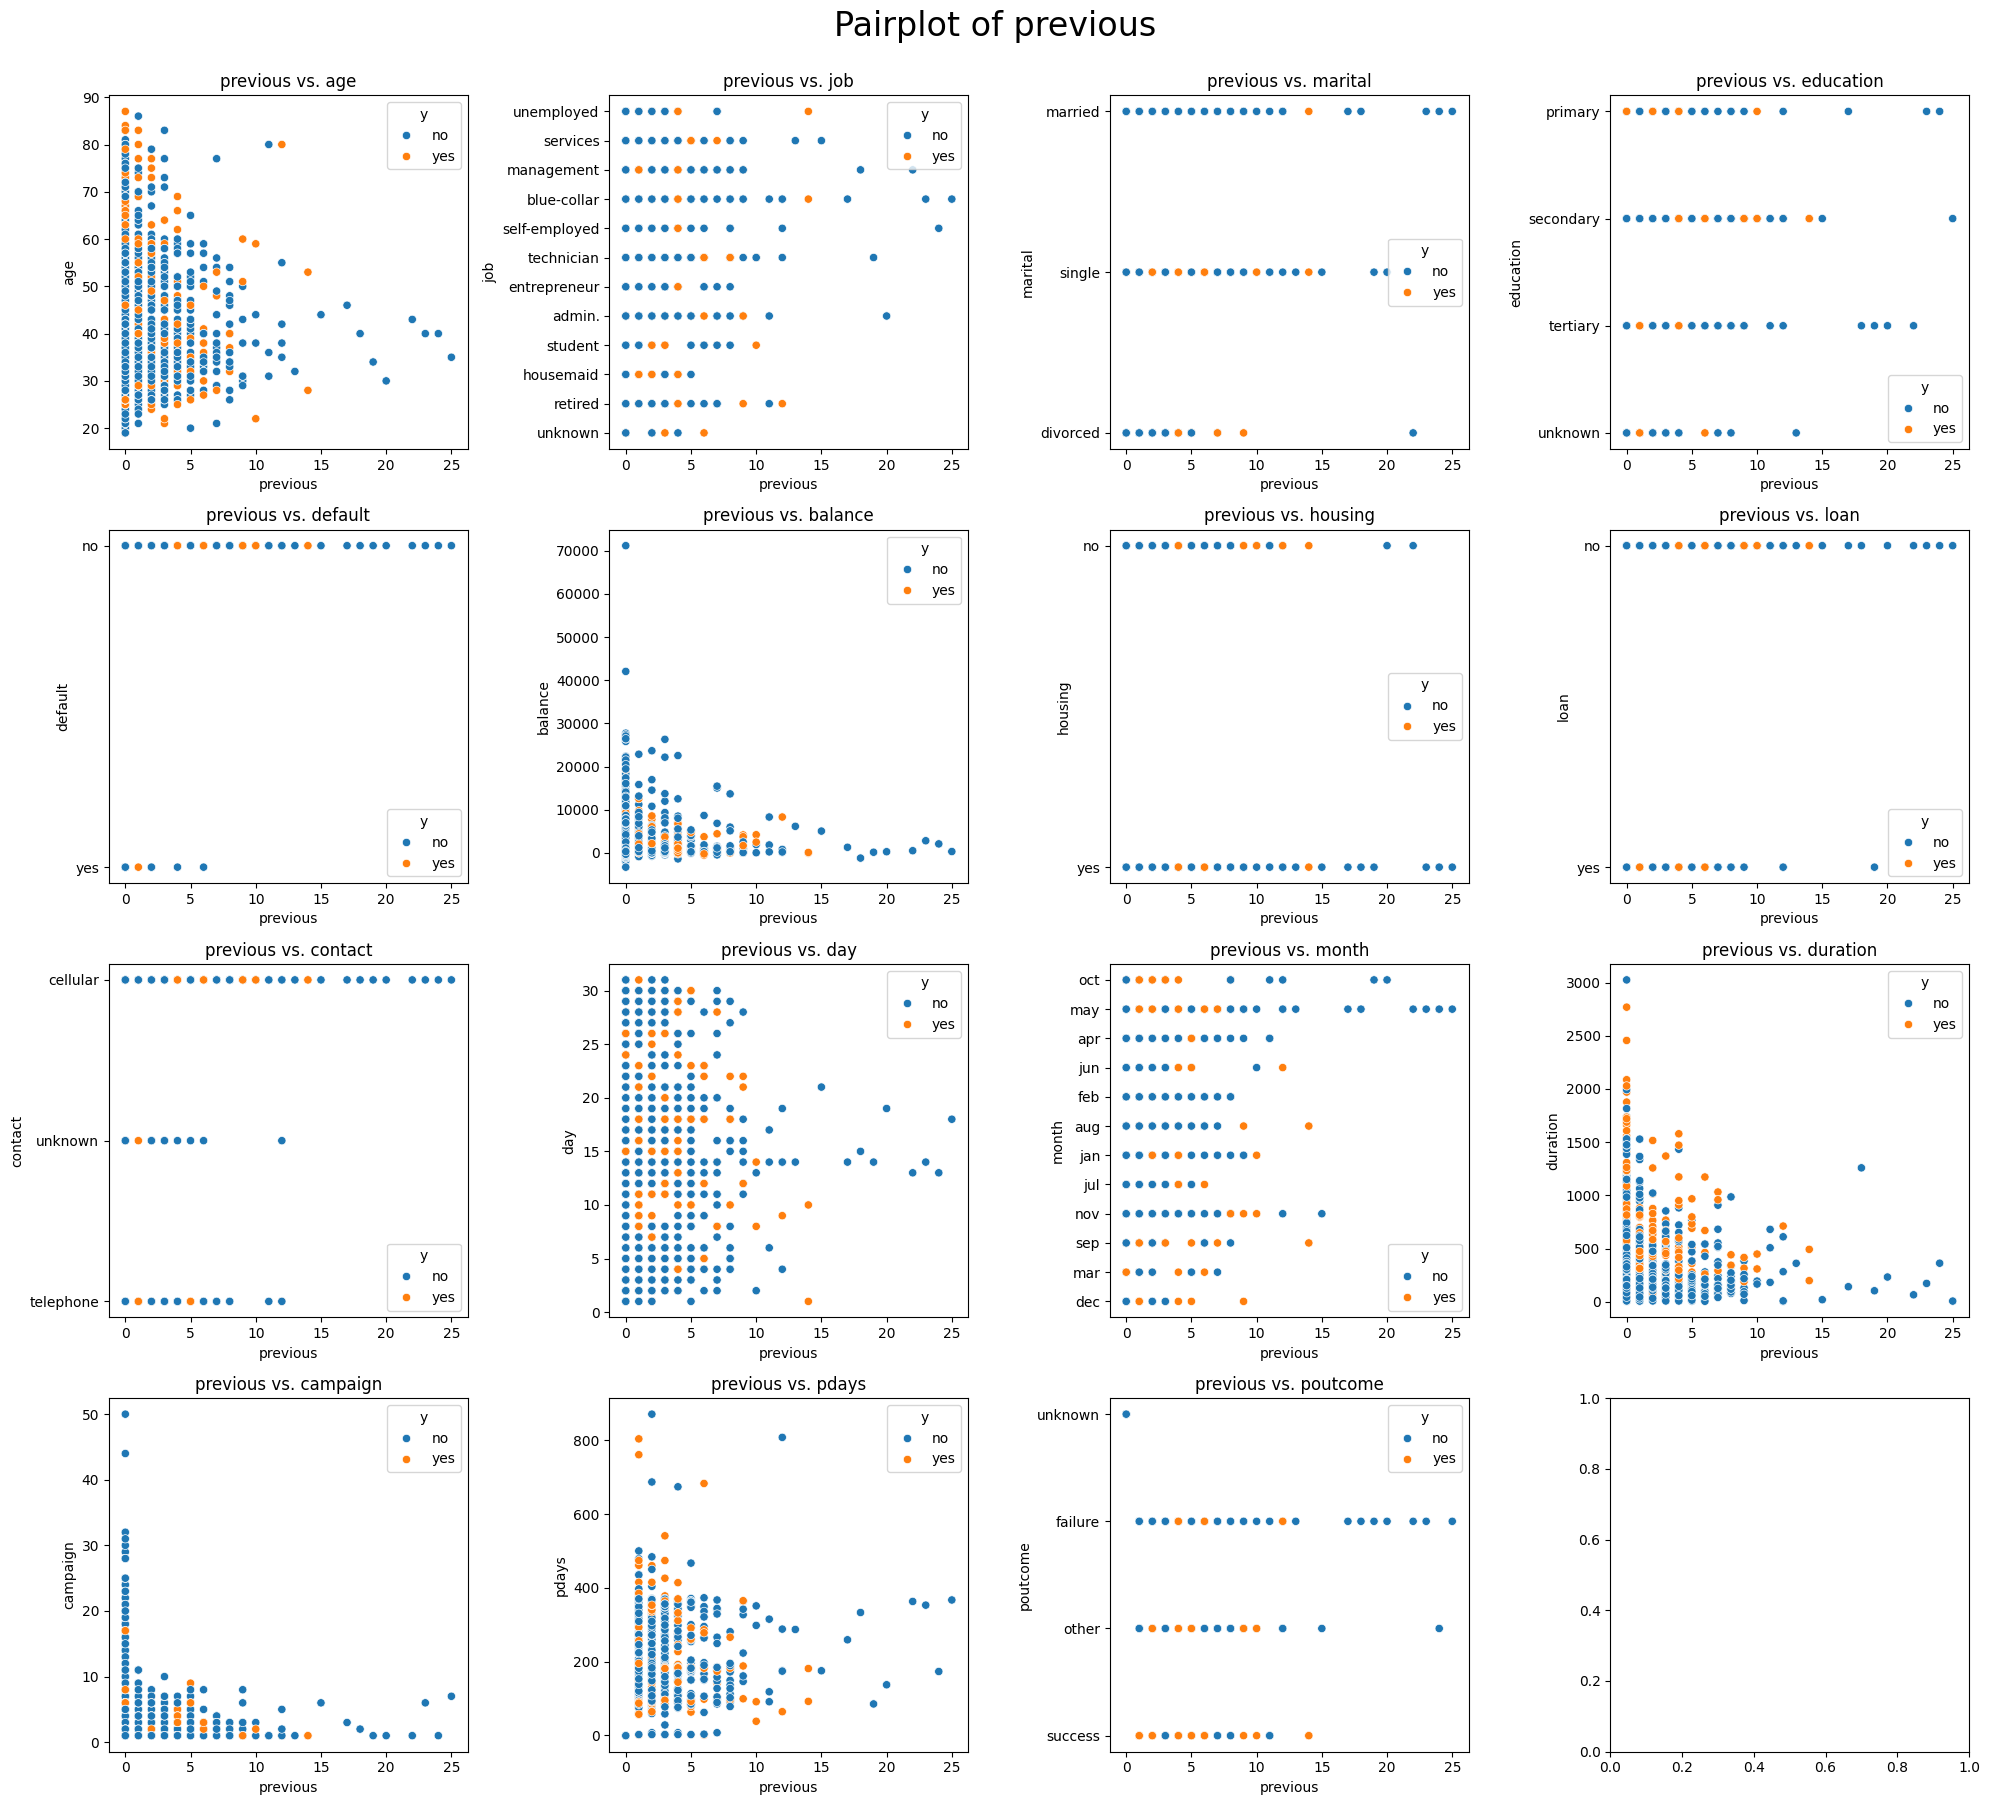

In [10]:
feature_names = features.columns
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for feature in numerical_features:
  fig, axes = plt.subplots(4, 4, figsize = (20, 20))
  axes = axes.flatten()

  fig.suptitle('Pairplot of {}'.format(feature), fontsize = 24, y = 0.9)

  other_features = [col for col in feature_names if col != feature]

  for ax, var in zip(axes, other_features):
    sns.scatterplot(data = bank, x = bank[feature], y = bank[var], ax = ax, hue = 'y')
    ax.set_title(f'{feature} vs. {var}')

  plt.tight_layout(rect = [0, 0, 1, 0.9])
  plt.show()

There's not much to see in the majority of the scatterplots. So many categorical variables makes it difficult to see direct correlations, and even in comparisons between numerical variables, there are basically no correlations.  
A few things you can see here:
 - Longer phone calls are correlated with more successful campaigns.
 - Higher age is correlated with more successful campaigns.

### Box Plots: Features vs. Target

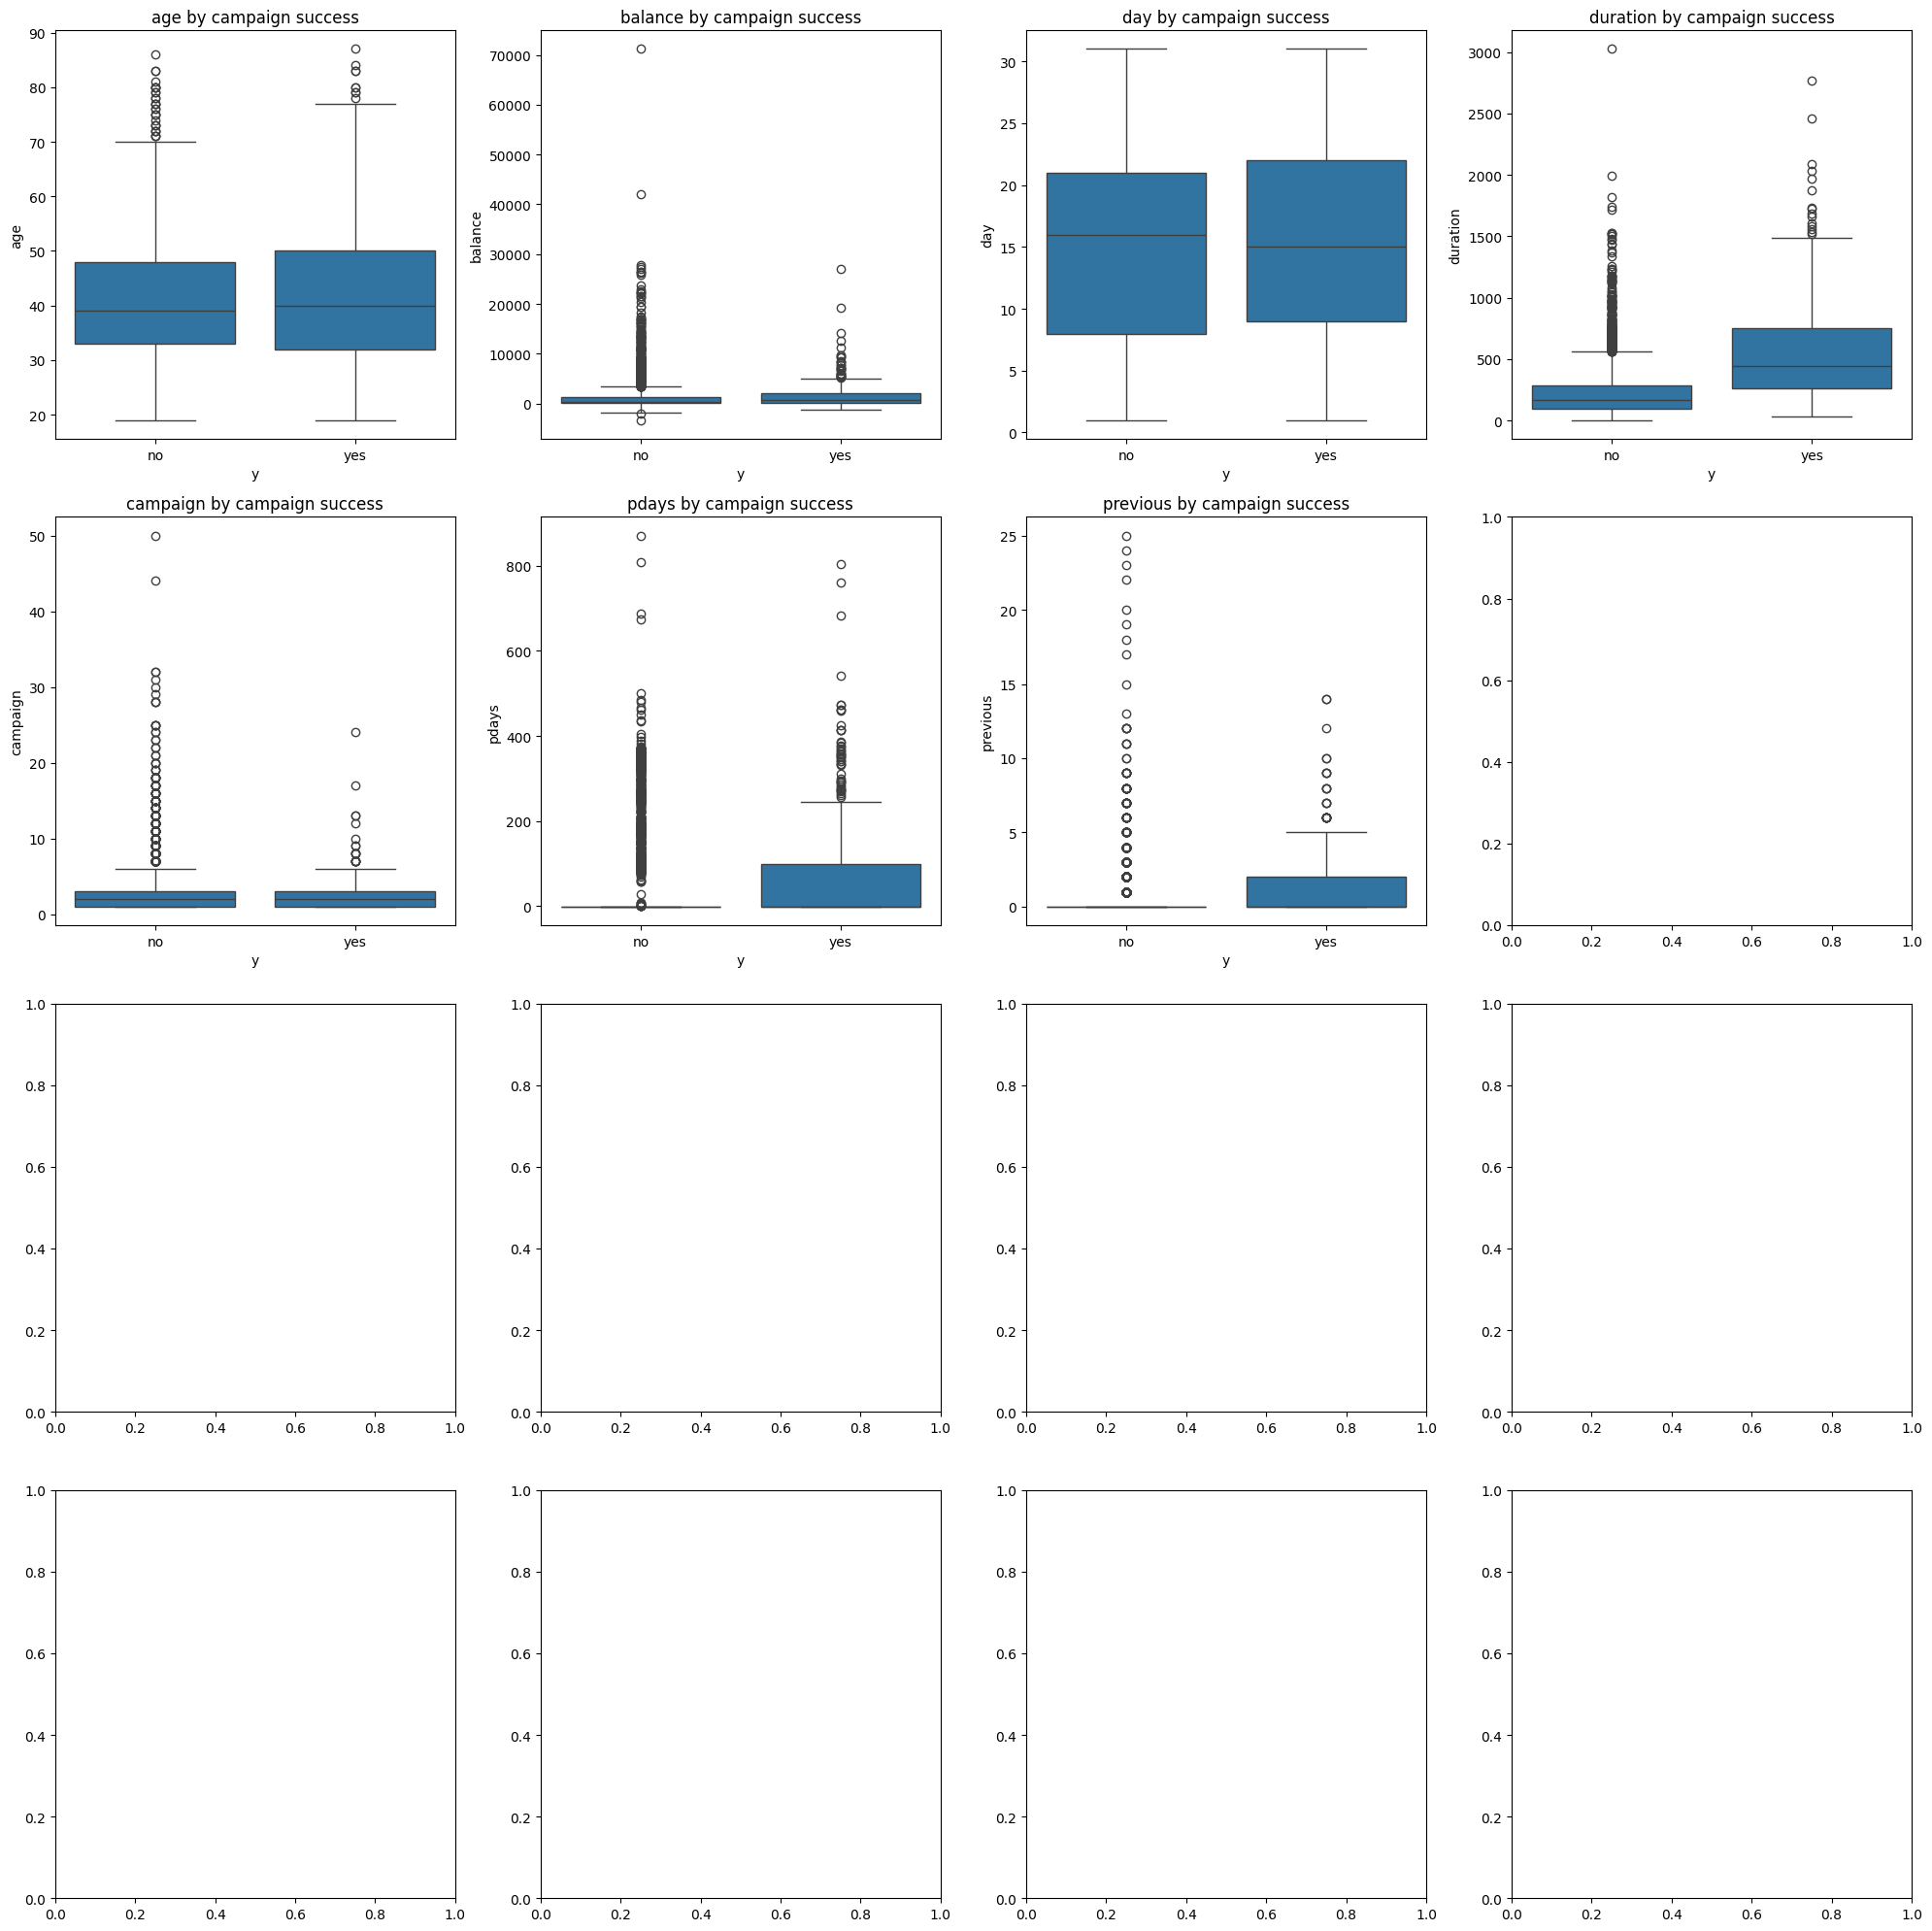

In [11]:
fig, axes = plt.subplots(4, 4, figsize = (20, 20))
axes = axes.flatten()

for ax, feature in zip(axes, numerical_features):
  sns.boxplot(data = bank, x = bank.y, y = bank[feature], ax = ax)
  ax.set_title(f'{feature} by campaign success')

plt.tight_layout()
plt.show()

Again, the high number of categorical variables keeps boxplots from being terribly useful. The only notable observation is a repeat from the scatterplots: longer duration is positively correlated with success. The correlation with age is less evident here than it was in the scatterplots.

## Pre-processing

In [12]:
le = LabelEncoder()

for col in bank.columns:
  if bank[col].dtype == 'object':
    bank[col] = le.fit_transform(bank[col])

bank.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   30   10        1          0        0     1787        0     0        0   
1   33    7        1          1        0     4789        1     1        0   
2   35    4        2          2        0     1350        1     0        0   
3   30    4        1          2        0     1476        1     1        2   
4   59    1        1          1        0        0        1     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  y  
0   19     10        79         1     -1         0         3  0  
1   11      8       220         1    339         4         0  0  
2   16      0       185         1    330         1         0  0  
3    3      6       199         4     -1         0         3  0  
4    5      8       226         1     -1         0         3  0

Categorical variables are encoded into numerical values, for use in ML models.

In [13]:
features = bank.drop(columns = 'y')
features.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   30   10        1          0        0     1787        0     0        0   
1   33    7        1          1        0     4789        1     1        0   
2   35    4        2          2        0     1350        1     0        0   
3   30    4        1          2        0     1476        1     1        2   
4   59    1        1          1        0        0        1     0        2   

   day  month  duration  campaign  pdays  previous  poutcome  
0   19     10        79         1     -1         0         3  
1   11      8       220         1    339         4         0  
2   16      0       185         1    330         1         0  
3    3      6       199         4     -1         0         3  
4    5      8       226         1     -1         0         3

The features include all columns except the outcome of a campaign.

In [14]:
target = bank.y
target.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

The campaign results are the target we'd like to predict.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 1)

The data is split into features and target for both training and testing sets.

## Model Training

### Decision Tree

In [16]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 1)

dtree = tree.DecisionTreeClassifier(random_state = 1)
param_grid = {
    'max_depth': list(range(1, 25)),
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(dtree, param_grid, cv = cv, scoring = 'accuracy')
grid.fit(X_train, y_train)

best_tree = grid.best_estimator_
scores = cross_val_score(best_tree, X_train, y_train, cv = cv)
scores = scores * 100

print(f'Best tree parameters: {best_tree}')
print(f'The fold accuracy scores for the model: {scores}')

Best tree parameters: DecisionTreeClassifier(max_depth=5, random_state=1)
The fold accuracy scores for the model: [91.71 89.76 89.21 90.59 91.15]


In [17]:
tree_pred_train = best_tree.predict(X_train)
tree_pred_test = best_tree.predict(X_test)

tree_accuracy_train = accuracy_score(y_train, tree_pred_train)
tree_accuracy_test = accuracy_score(y_test, tree_pred_test)

lb, ub = classification_confint(tree_accuracy_test, len(y_test))

print('Decision tree training accuracy: {:.2}%'.format(tree_accuracy_train))
print('Decision tree testing accuracy: {:.2}%'.format(tree_accuracy_test))
print('Confidence interval of testing accuracy: {:.2} - {:.2}'.format(lb, ub))

Decision tree training accuracy: 0.93%
Decision tree testing accuracy: 0.88%
Confidence interval of testing accuracy: 0.86 - 0.9


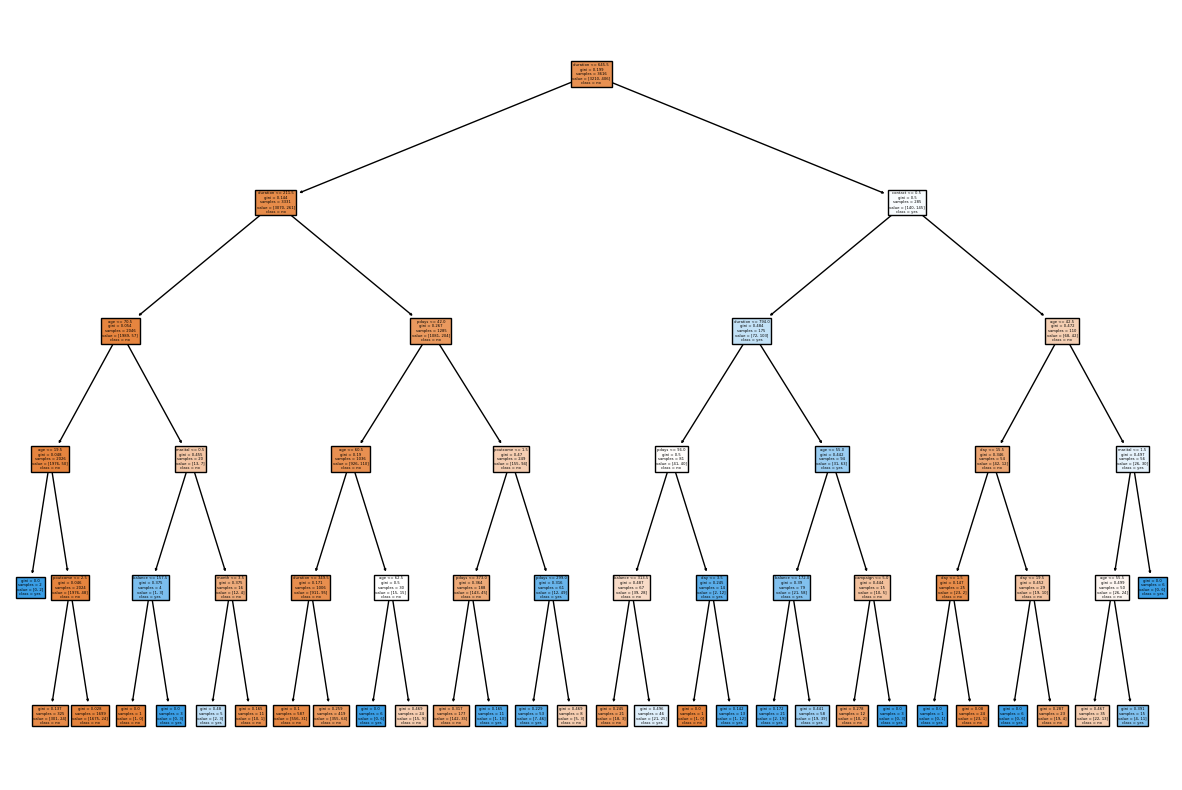

In [18]:
plt.figure(figsize = (15, 10))
tree.plot_tree(best_tree, filled = True, feature_names = features.columns, class_names = ['no', 'yes'])
plt.show()

#### Model Interpretation:  
  
Clearly, the most important determinant of success appears to be the duration of a phone call. The longer a customer continues to speak (and presumably maintain interest), the more likely the bank succeeds. More investigation would likely need to be done into what specifically keeps a customer on the phone.

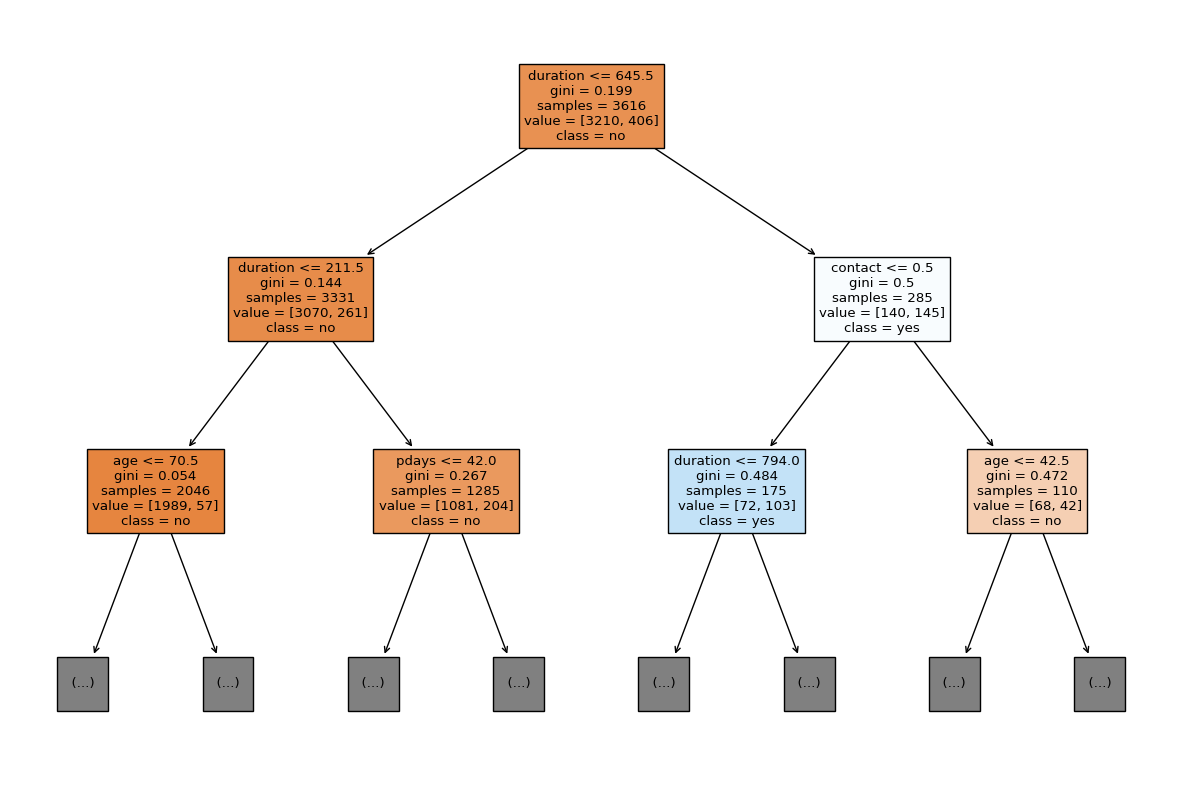

In [19]:
plt.figure(figsize = (15, 10))
tree.plot_tree(best_tree, filled = True, feature_names = features.columns, class_names = ['no', 'yes'], max_depth = 2)
plt.show()

### k-NN Classifier

In [20]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [21]:
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

knn_accuracy_train = accuracy_score(y_train, knn_pred_train)
knn_accuracy_test = accuracy_score(y_test, knn_pred_test)

lb, ub = classification_confint(knn_accuracy_test, X_test.shape[0])

print('k-NN training accuracy: {:.2}%'.format(knn_accuracy_train))
print('k-NN testing accuracy: {:.2}%'.format(knn_accuracy_test))
print('Confidence interval of testing accuracy: {:.2} - {:.2}'.format(lb, ub))

k-NN training accuracy: 0.92%
k-NN testing accuracy: 0.87%
Confidence interval of testing accuracy: 0.85 - 0.89


#### Model Interpretation

The importances below show that three features appear to stand out in importance, relative to the others:
 - Duration is clearly the most important, which makes sense, according to the exploratory analysis's boxplots.
 - Interestingly, balance and pdays appear second and third respectively. Neither appeared terribly important in earlier analysis, but this model disagrees.

In [22]:
importances = permutation_importance(knn, X_train, y_train, n_repeats = 10, random_state = 1)

for i in range(X_train.shape[1]):
  print("Feature {:.4}: {:.4f} +/- {:.4f}".format(feature_names[i], importances.importances_mean[i], importances.importances_std[i]))

Feature age: 0.0009 +/- 0.0005
Feature job: 0.0002 +/- 0.0002
Feature mari: 0.0000 +/- 0.0000
Feature educ: 0.0000 +/- 0.0000
Feature defa: 0.0000 +/- 0.0000
Feature bala: 0.0338 +/- 0.0024
Feature hous: 0.0000 +/- 0.0000
Feature loan: 0.0000 +/- 0.0000
Feature cont: 0.0000 +/- 0.0000
Feature day: 0.0001 +/- 0.0005
Feature mont: 0.0003 +/- 0.0002
Feature dura: 0.0492 +/- 0.0023
Feature camp: -0.0001 +/- 0.0001
Feature pday: 0.0205 +/- 0.0015
Feature prev: 0.0000 +/- 0.0000
Feature pout: 0.0000 +/- 0.0000


### Support Vector Machine

In [23]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

model = SVC(max_iter = 10000)

search_space = {
    'C': Real(1e-3, 1e3, prior = 'log-uniform'),
    'gamma': Real(1e-3, 1e3, prior = 'log-uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'probability': [True]
}

bayes_search = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=32, cv=cv, scoring='accuracy', n_jobs=-1, random_state=1)

bayes_search.fit(X_train, y_train)

best_svm = bayes_search.best_estimator_
scores = cross_val_score(best_svm, X_train, y_train, cv = cv)
scores = scores * 100

print('Best SVM parameters: {}'.format(best_svm))
print('The fold accuracy scores for the model: {}'.format(scores))

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 1000.0, 'rbf', True] before, using random point [0.005464578831847708, 0.012612463681762415, 'sigmoid', True]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 1000.0, 'rbf', True] before, using random point [473.2871071434284, 0.0018491172920223464, 'poly', True]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 1000.0, 'rbf', True] before, using random point [0.5387506271529175, 7.747951128120306, 'poly', True]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 1000.0, 'rbf', True] before, using random point [0.010576959856675647, 2.68097216331

Best SVM parameters: SVC(C=638.8439386591792, gamma=0.38792938414429573, max_iter=10000,
    probability=True)
The fold accuracy scores for the model: [90.06 87.83 87.83 88.66 89.49]


In [24]:
best_svm.kernel

'rbf'

In [25]:
svm_pred_train = best_svm.predict(X_train)
svm_pred_test = best_svm.predict(X_test)

svm_accuracy_train = accuracy_score(y_train, svm_pred_train)
svm_accuracy_test = accuracy_score(y_test, svm_pred_test)

lb, ub = classification_confint(svm_accuracy_test, X_test.shape[0])

print('SVM training accuracy: {:.2}%'.format(svm_accuracy_train))
print('SVM testing accuracy: {:.2}%'.format(svm_accuracy_test))
print('Confidence interval of testing accuracy: {:.2} - {:.2}'.format(lb, ub))

SVM training accuracy: 1.0%
SVM testing accuracy: 0.87%
Confidence interval of testing accuracy: 0.85 - 0.89


#### Model Interpretation

In [26]:
importances = permutation_importance(best_svm, X_train, y_train, n_repeats = 10, random_state = 1)

for i in range(X_train.shape[1]):
  print("Feature {:.4}: {:.4f} +/- {:.4f}".format(feature_names[i], importances.importances_mean[i], importances.importances_std[i]))

Feature age: 0.1032 +/- 0.0011
Feature job: 0.0804 +/- 0.0023
Feature mari: 0.0082 +/- 0.0012
Feature educ: 0.0155 +/- 0.0017
Feature defa: 0.0000 +/- 0.0000
Feature bala: 0.1116 +/- 0.0004
Feature hous: 0.0000 +/- 0.0000
Feature loan: 0.0000 +/- 0.0000
Feature cont: 0.0338 +/- 0.0024
Feature day: 0.1008 +/- 0.0015
Feature mont: 0.0807 +/- 0.0019
Feature dura: 0.1119 +/- 0.0002
Feature camp: 0.0472 +/- 0.0025
Feature pday: 0.0530 +/- 0.0018
Feature prev: 0.0360 +/- 0.0015
Feature pout: 0.0308 +/- 0.0015


Interestingly, the SVM's priorities are quite different from teh previous two models. Again, duration is quite important, but hardly any more than balance. Additionally, features like age and day matter nearly as much as the first two, and features like prev, pout, job, and others all weigh in meaningfully, which wasn't the case previously.  
This rather seems like the SVM is working in a way that's nearly incomprehensible to human thinking; day and job being meaningful would be rather confusing. To me, this indicates that the model is picking up on noise in the data, or working in a way that a bank marketing campaign couldn't replicate.

### Neural Network

In [27]:
one_layer = list(range(10, 22))
two_layer = [10 for _ in range(11)]
single_mlp = [(num,) for num in one_layer]
double_mlp = [(num1, num2) for num1, num2 in zip(one_layer, two_layer)]

hls = single_mlp + double_mlp
print(single_mlp)
print(double_mlp)
print(hls)

[(10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,)]
[(10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10)]
[(10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10)]


In [28]:
nn = MLPClassifier(max_iter = 10000, random_state = 1)
param_grid = {
    'hidden_layer_sizes': hls,
    'activation': ['logistic', 'tanh', 'relu']
}
grid = GridSearchCV(nn, param_grid, cv = cv)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=MLPClassifier(max_iter=10000, random_state=1),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (11,), (12,), (13,),
                                                (14,), (15,), (16,), (17,),
                                                (18,), (19,), (20,), (21,),
                                                (10, 10), (11, 10), (12, 10),
                                                (13, 10), (14, 10), (15, 10),
                                                (16, 10), (17, 10), (18, 10),
                                                (19, 10), (20, 10)]})

In [29]:
best_nn = grid.best_estimator_
scores = cross_val_score(best_nn, X_train, y_train, cv = cv)
scores = scores * 100

print(f'Best NN parameters: {best_nn}')
print("The fold accuracy scores for the model: {}".format(scores))

Best NN parameters: MLPClassifier(activation='tanh', hidden_layer_sizes=(15, 10), max_iter=10000,
              random_state=1)
The fold accuracy scores for the model: [91.02 87.55 88.24 88.8  89.35]


In [30]:
nn_pred_train = best_nn.predict(X_train)
nn_pred_test = best_nn.predict(X_test)

nn_accuracy_train = accuracy_score(y_train, nn_pred_train)
nn_accuracy_test = accuracy_score(y_test, nn_pred_test)

lb, ub = classification_confint(nn_accuracy_test, X_test.shape[0])

print('Neural network training accuracy: {:.2}%'.format(nn_accuracy_train))
print('Neural network testing accuracy: {:.2}%'.format(nn_accuracy_test))
print('Confidence interval of testing accuracy: {:.2} - {:.2}'.format(lb, ub))

Neural network training accuracy: 0.89%
Neural network testing accuracy: 0.88%
Confidence interval of testing accuracy: 0.85 - 0.9


#### Model Interpretation

In [38]:
importances = permutation_importance(best_nn, X_train, y_train, n_repeats = 10, random_state = 1)

for i in range(X_train.shape[1]):
  print("Feature {:.4}: {:.4f} +/- {:.4f}".format(feature_names[i], importances.importances_mean[i], importances.importances_std[i]))

Feature age: -0.0006 +/- 0.0007
Feature job: -0.0007 +/- 0.0004
Feature mari: -0.0003 +/- 0.0002
Feature educ: -0.0000 +/- 0.0001
Feature defa: -0.0000 +/- 0.0001
Feature bala: -0.0017 +/- 0.0023
Feature hous: -0.0002 +/- 0.0001
Feature loan: 0.0000 +/- 0.0000
Feature cont: -0.0001 +/- 0.0002
Feature day: -0.0009 +/- 0.0008
Feature mont: 0.0004 +/- 0.0004
Feature dura: 0.0164 +/- 0.0035
Feature camp: -0.0000 +/- 0.0005
Feature pday: 0.0025 +/- 0.0015
Feature prev: 0.0005 +/- 0.0001
Feature pout: -0.0006 +/- 0.0001


Again duration is the clear leader in terms of feature importance, but large standard deviations mean that many of these values really can't be meaningfully compared with each other.

## Model Evaluation

In [32]:
labels = ['no', 'yes']

dtree_cm = confusion_matrix(y_test, tree_pred_test)
dcm_df = pd.DataFrame(dtree_cm, index = labels, columns = labels)
dcm_df.index.name = 'Actual'
dcm_df.columns.name = 'Predicted'
print('Optimal Tree Confusion Matrix: \n\n{}'.format(dcm_df))

Optimal Tree Confusion Matrix: 

Predicted   no  yes
Actual             
no         759   31
yes         80   35


In [33]:
knn_cm = confusion_matrix(y_test, knn_pred_test)
kcm_df = pd.DataFrame(knn_cm, index = labels, columns = labels)
kcm_df.index.name = 'Actual'
kcm_df.columns.name = 'Predicted'
print('Optimal k-NN Confusion Matrix: \n\n{}'.format(kcm_df))

Optimal k-NN Confusion Matrix: 

Predicted   no  yes
Actual             
no         774   16
yes        100   15


In [34]:
svm_cm = confusion_matrix(y_test, svm_pred_test)
scm_df = pd.DataFrame(svm_cm, index = labels, columns = labels)
scm_df.index.name = 'Actual'
scm_df.columns.name = 'Predicted'
print('Optimal SVM Confusion Matrix: \n\n{}'.format(scm_df))

Optimal SVM Confusion Matrix: 

Predicted   no  yes
Actual             
no         790    0
yes        115    0


In [35]:
nn_cm = confusion_matrix(y_test, nn_pred_test)
ncm_df = pd.DataFrame(nn_cm, index = labels, columns = labels)
ncm_df.index.name = 'Actual'
ncm_df.columns.name = 'Predicted'
print('Optimal Neural Network Confusion Matrix: \n\n{}'.format(ncm_df))

Optimal Neural Network Confusion Matrix: 

Predicted   no  yes
Actual             
no         781    9
yes        103   12


In [36]:
tree_precision = precision_score(y_test, tree_pred_test)
knn_precision = precision_score(y_test, knn_pred_test)
svm_precision = precision_score(y_test, svm_pred_test)
nn_precision = precision_score(y_test, nn_pred_test)

print('Decision tree precision: {:.2}'.format(tree_precision))
print('k-NN precision: {:.2}'.format(knn_precision))
print('SVM precision: {:.2}'.format(svm_precision))
print('Neural network precision: {:.2}'.format(nn_precision))

Decision tree precision: 0.53
k-NN precision: 0.48
SVM precision: 0.0
Neural network precision: 0.57


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
tree_balanced_accuracy = balanced_accuracy_score(y_test, tree_pred_test)
knn_balanced_accuracy = balanced_accuracy_score(y_test, knn_pred_test)
svm_balanced_accuracy = balanced_accuracy_score(y_test, svm_pred_test)
nn_balanced_accuracy = balanced_accuracy_score(y_test, nn_pred_test)

print('Decision tree balanced accuracy: {:.2}'.format(tree_balanced_accuracy))
print('k-NN balanced accuracy: {:.2}'.format(knn_balanced_accuracy))
print('SVM balanced accuracy: {:.2}'.format(svm_balanced_accuracy))
print('Neural network balanced accuracy: {:.2}'.format(nn_balanced_accuracy))

Decision tree balanced accuracy: 0.63
k-NN balanced accuracy: 0.56
SVM balanced accuracy: 0.5
Neural network balanced accuracy: 0.55


In the end, the best model is decidedly the decision tree. It's a relatively simple model, just a tree with a depth of 5, which makes it much less computationally expensive than the other models, and it also does the best in basically every metric that matters:

 - It has the highest raw testing accuracy score, indicating the best ability to parse the data.
 - Its confusion matrix yields the lowest missed opportunities.
 - It is the most precise model when it comes to finding the customers we want to target.  
   
It makes some intuitive sense that this model is best, if you compare with the exploratory analysis. From the analysis, the clearest correlation between any feature vs. the target was a positive correlation between call duration and success, while the decision tree's first few layers involve many questions about call duration.  
  
A little more surprising are the relative importance of a customer's balance, and the pdays variable, which measures how many days ago a customer was last contacted as part of the campaign. There were no obvious correlations between these features and campaign sucess, but evidently these factors matter. These are things which the bank will likely want to consider when deciding how to handle their marketing.